In [1]:
import source_synphot.passband
import source_synphot.io
import source_synphot.source
import astropy.table as at
from collections import OrderedDict
import pysynphot as S
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
%matplotlib notebook

from scipy.optimize import minimize
from astropy.stats import sigma_clip

In [2]:
def myround(x, prec=2, base=.5):
    return round(base * round(float(x)/base),prec)

In [43]:
models = at.Table.read('ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
model_sed = source_synphot.source.load_source(model_sed_names)

/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod44852_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod42857_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod40862_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod39865_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod40300_0.0_3.50 not loaded
  warnings.warn(message, RuntimeWarning)
/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod39000_0.0_3.00 not loaded
  w

In [44]:
model_sed

OrderedDict([('ckmod38867_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x131d420ac8>),
             ('ckmod37870_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x131d413978>),
             ('ckmod36872_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x131d413828>),
             ('ckmod35874_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x131d4245c0>),
             ('ckmod34877_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x131c9f3390>),
             ('ckmod33879_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x131d3e1cf8>),
             ('ckmod32882_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x131d415668>),
             ('ckmod31884_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x131d3db1d0>),
             ('ckmod30000_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x131ca22f98>),
          

In [4]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

In [6]:
color1 = 'ps1g_ps1r'
color2 = 'ps1r_ps1i'
col1 = []
col2 = []
col3 = []
col4 = []
col5 = []
# construct color-color vectors
for modelname in model_sed:
    model= model_sed[modelname]
    model = S.ArraySpectrum(model.wave, model.flux, name=modelname)
    c1, c2 = color1.split('_')
    pb1, zp1 = pbs[c1]
    pb2, zp2 = pbs[c2]
    c3, c4 = color2.split('_')
    c5 = 'Kep'
    pb3, zp3 = pbs[c3]
    pb4, zp4 = pbs[c4]
    pb5, zp5 = pbs[c5]
    thiscol1 = source_synphot.passband.syncolor(model, pb1, pb2, zp1, zp2)
    thiscol2 = source_synphot.passband.syncolor(model, pb3, pb4, zp3, zp4)
    thiscol3 = source_synphot.passband.syncolor(model, pb5, pb3, zp5, zp3)
    thiscol4 = source_synphot.passband.syncolor(model, pb5, pb4, zp5, zp4)
    thiscol5 = source_synphot.passband.syncolor(model, pb1, pb5, zp1, zp5)
    col1.append(thiscol1)
    col2.append(thiscol2)
    col3.append(thiscol3)
    col4.append(thiscol4)
    col5.append(thiscol5)
col1 = np.array(col1)
col2 = np.array(col2)
col3 = np.array(col3)
col4 = np.array(col4)
col5 = np.array(col5)
# select only useful objects
good = ~np.isnan(col1)* ~np.isnan(col2)* ~np.isnan(col3)* ~np.isnan(col4)* ~np.isnan(col5)
good = np.array(good)

In [7]:
from astroML.plotting import scatter_contour
from astroML.datasets import fetch_sdss_S82standards
from astroML.plotting import setup_text_plots
import pandas as pd
#setup_text_plots(fontsize=8, usetex=True)

data = pd.read_csv('../calibration/kepler/K2_all_PS1_psc_ev.csv')
data = data.iloc[(data['ps_score'].values > 0.9) & (data['PDC'].values > 0)]
cind =  ((data['campaign'].values == 16) & (data['Channel'].values == 70))
gb = data['gMeanPSFMag'].values
gbe = data['gMeanPSFMagErr'].values * 1.005
rb = data['rMeanPSFMag'].values
rbe = data['rMeanPSFMagErr'].values * 1.005
ib = data['iMeanPSFMag'].values
ibe = data['iMeanPSFMagErr'].values * 1.005
kb = -2.5*np.log10(data['PDC'].values)
kbe = 0.434 * np.abs(data['PDCe'].values/110) / np.abs(data['PDC'].values)

In [294]:
np.nanmax(kbe)

113914855151.09985

In [58]:
len(data)

140399

<IPython.core.display.Javascript object>


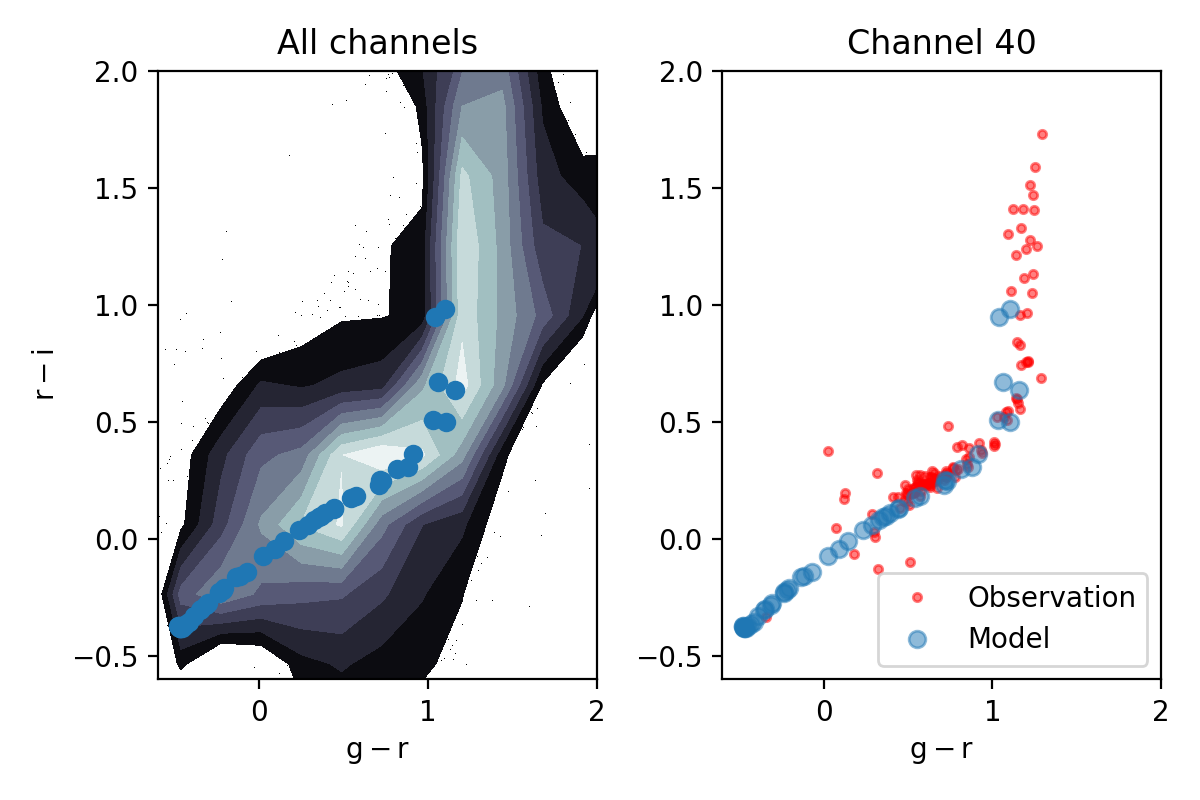

In [59]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplot(1,2,1)
ax = plt.gca()
plt.title('All channels')
scatter_contour(g - r , r - i, threshold=20, log_counts=True, ax=ax,
                histogram2d_args=dict(bins=40),
                plot_args=dict(marker=',', linestyle='none', color='black'),
                contour_args=dict(cmap=plt.cm.bone))

ax.set_xlabel(r'${\rm g - r}$')
ax.set_ylabel(r'${\rm r - i}$')

ax.set_xlim(-0.6, 2)
ax.set_ylim(-0.6, 2)
plt.plot(col1[good], col2[good], marker='o', linestyle='None',label='Model')

plt.subplot(1,2,2)
plt.title('Channel 40')

plt.xlabel(r'${\rm g - r}$')
ax.set_ylabel(r'${\rm r - i}$')
plt.plot((g - r)[cind], (r - i)[cind],'.',c='r',alpha=0.5,label = 'Observation')
plt.xlim(-0.6, 2)
plt.ylim(-0.6, 2)
plt.plot(col1[good], col2[good],alpha=0.5, marker='o', linestyle='None',label='Model')

plt.legend()

plt.tight_layout()
#plt.savefig('K2_r-i.png')

<IPython.core.display.Javascript object>


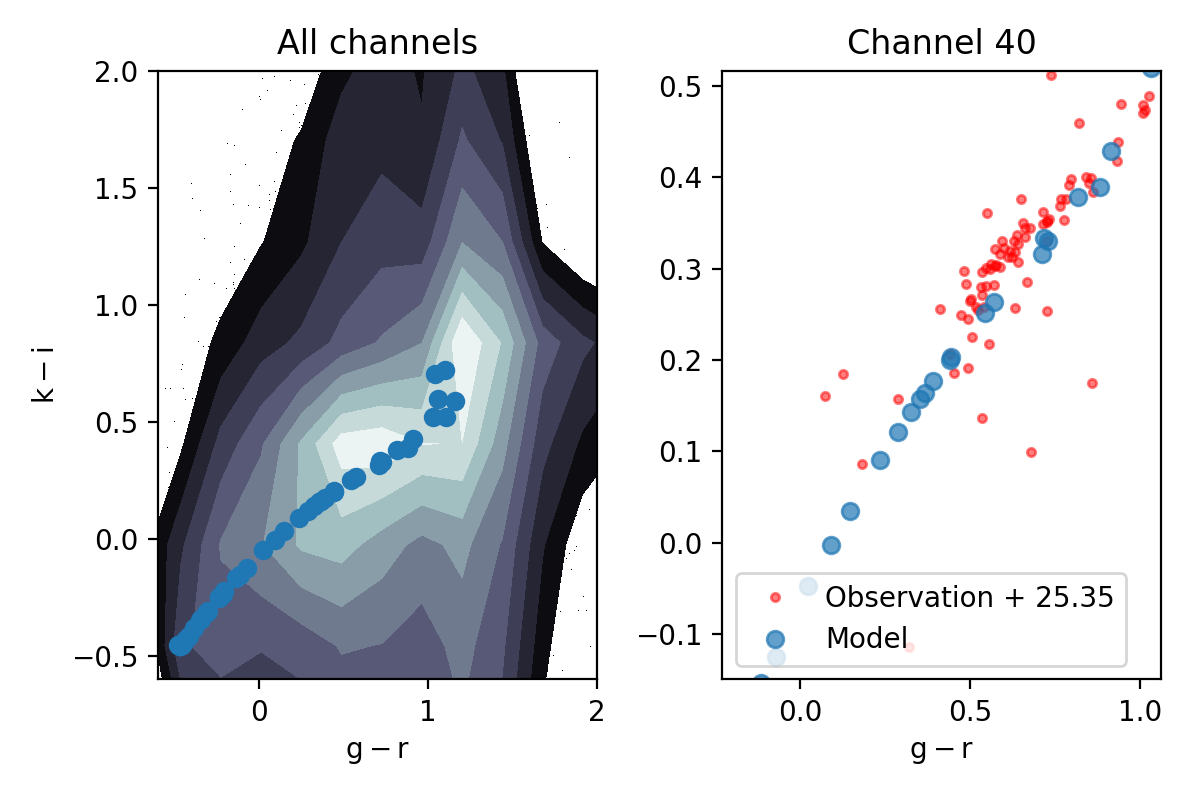

In [64]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplot(1,2,1)
ax = plt.gca()
plt.title('All channels')
scatter_contour(g - r, k - i+25.35, threshold=20, log_counts=True, ax=ax,
                histogram2d_args=dict(bins=40),
                plot_args=dict(marker=',', linestyle='none', color='black'),
                contour_args=dict(cmap=plt.cm.bone))

ax.set_xlabel(r'${\rm g - r}$')
ax.set_ylabel(r'${\rm k - i}$')

ax.set_xlim(-0.6, 2)
ax.set_ylim(-0.6, 2)
plt.plot(col1[good], col3[good], marker='o', linestyle='None',label='Model')

plt.subplot(1,2,2)
plt.title('Channel 40')

plt.xlabel(r'${\rm g - r}$')
ax.set_ylabel(r'${\rm k - i}$')
plt.plot((g - r)[cind], (k - i)[cind]+25.35,'r.',alpha=0.5,label = 'Observation + 25.35')
plt.xlim(-0.6, 2)
plt.ylim(-0.6, 2)
plt.plot(col1[good], col3[good],alpha=0.7, marker='o', linestyle='None',label='Model')

plt.legend()

plt.tight_layout()
#plt.savefig('K2_k-i.png')

In [173]:
gr_interp = np.arange(np.nanmin(col1[good]),1,0.01)
inter = interpolate.interp1d(col1[good],col3[good])
ki_interp = inter(gr_interp)

<IPython.core.display.Javascript object>


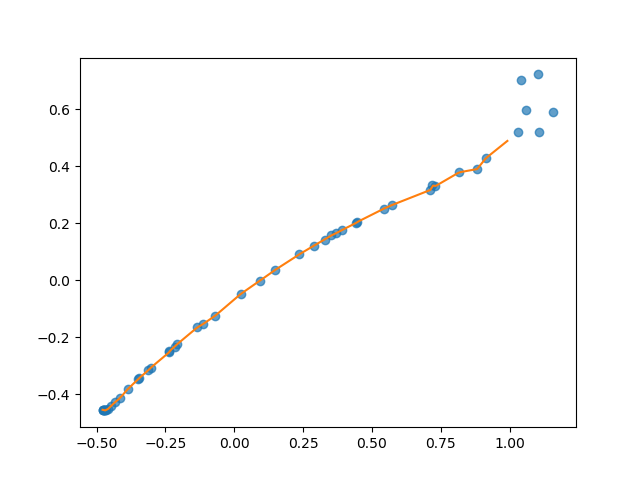

In [175]:
plt.figure()
plt.plot(col1[good], col3[good],alpha=0.7, marker='o', linestyle='None',label='Model')
plt.plot(gr_interp,ki_interp)

In [80]:
len(ki_interp)

148

In [136]:
C = np.array([(g - r)[cind],(k - i)[cind]])

In [137]:
C.shape

(2, 123)

In [138]:
thing = []
for i in range(C.shape[1]):
    dist = np.sqrt((C[0,i] -gr_interp)**2 + (C[1,i] - ki_interp)**2)
    thing += [dist]
thing = np.array(thing)

In [139]:
mins = np.nanmin(thing,axis=1)

In [140]:
np.nansum(mins)

3017.130279528216

In [8]:
def SLR_fit(K, Observed, Locus,Second):
    
    if len(K) > 1:
        zp = K[0]
        A = K[1:]
    else:
        zp = K[0]
        A = np.zeros(3)
    x_interp = np.arange(np.nanmin(Locus[0,:]),1,0.01)
    inter = interpolate.interp1d(Locus[0,:],Locus[1,:])
    l_interp = inter(x_interp)
    locus = np.array([x_interp,l_interp])
    
    c = Observed.copy() 
    ind = np.where((c[0,:] <= 1) & (c[0,:] > 0.5))[0]
    c = c[:,ind]
    c[1,:] = c[1,:] + zp + A[2] - A[1]
    c[0,:] = c[0,:] + A[0] - A[1]
    
    #print(c[1,:])
    dist_tensor = []
    for i in range(c.shape[1]):
        dist = np.sqrt((c[0,i] - locus[0,:])**2 + (c[1,i] - locus[1,:])**2) 
        if Second:
            #print('cut')
            # Quality control
            #dist[dist > 6*(c[2,i])] = np.nan
            dist[dist > 1] = np.nan
        #else:
            #print('first')
        # add the normalised distance
        dist_tensor += [dist / c[2,i]]
    dist_tensor = np.array(dist_tensor)
    if len(dist_tensor) > 2:
        residual = np.nansum(np.nanmin(abs(dist_tensor),axis=1))
    else:
        residual = 1000
    #print(residual)
    return residual
    

In [222]:
locus = np.array([col1[good],col3[good]])
obs = np.array([(gb - rb)[cind],(kb - rb)[cind]])
K0 = 25
k0 = [25,0,0,0]
#kbds = [(20,26)]
res = minimize(SLR_fit,K0,args=(obs,locus))

In [223]:
res.x

array([25.36800123])

<IPython.core.display.Javascript object>


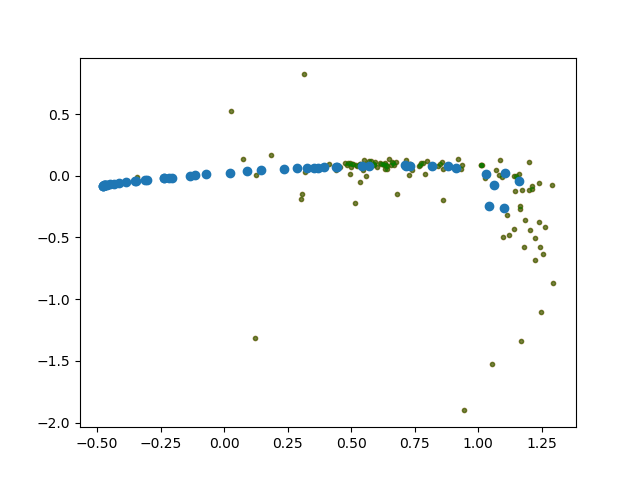

In [224]:
K = res.x
if len(K) > 1:
    zp = K[0]
    A = K[1:]
else:
    zp = K[0]
    A = np.zeros(3)

plt.figure()
plt.plot(obs[0,:]+ A[0] - A[1], obs[1,:]+ zp + A[2] - A[1],'r.',alpha=0.5)
plt.plot(obs[0,:], obs[1,:]+ 25.368,'g.',alpha=0.5)
#plt.xlim(-0.6, 2)
#plt.ylim(-0.6, 2)
plt.plot(locus[0,:], locus[1,:],'o')


/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


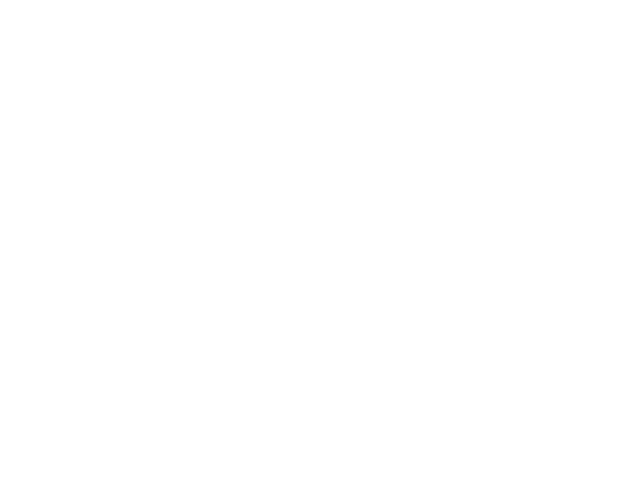

<IPython.core.display.Javascript object>


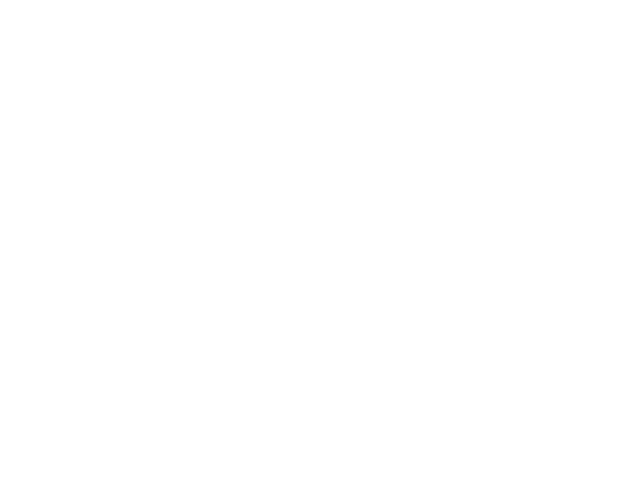

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


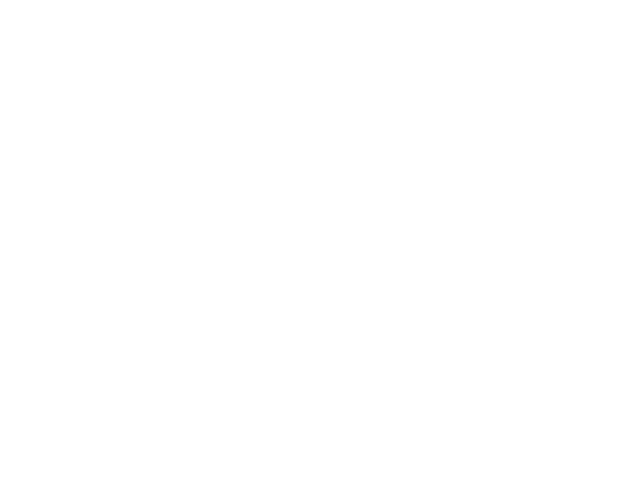

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


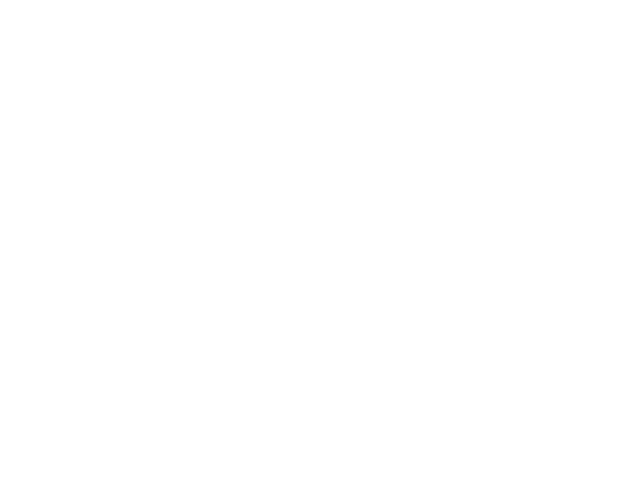

<IPython.core.display.Javascript object>


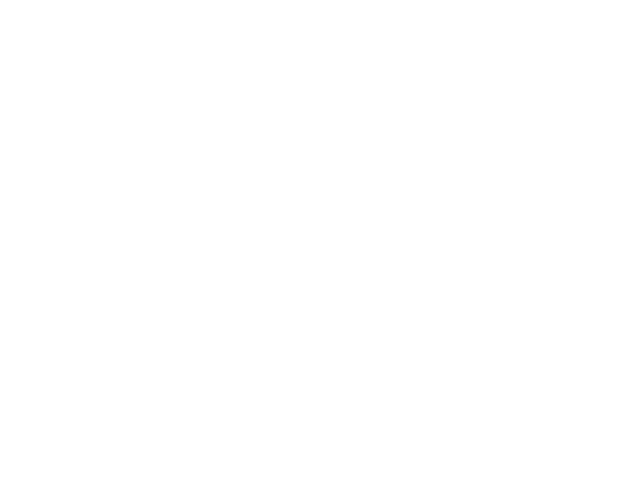

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


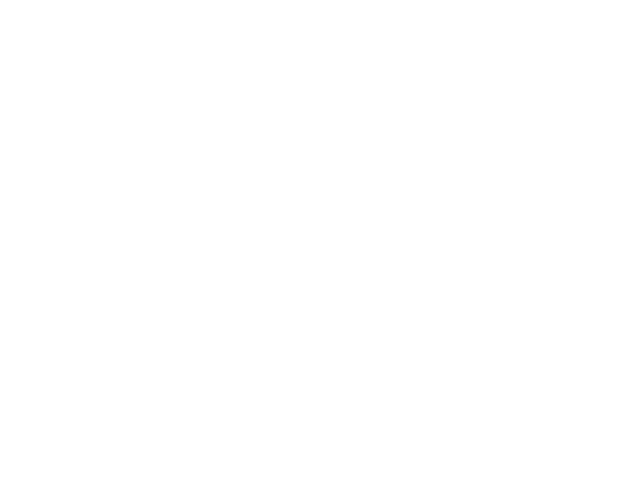

<IPython.core.display.Javascript object>


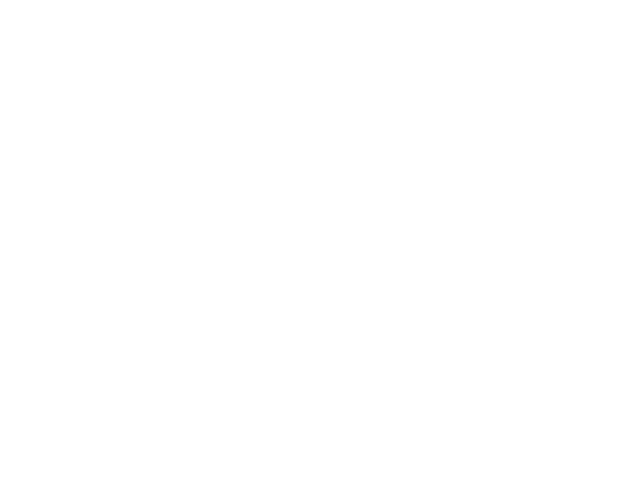

<IPython.core.display.Javascript object>


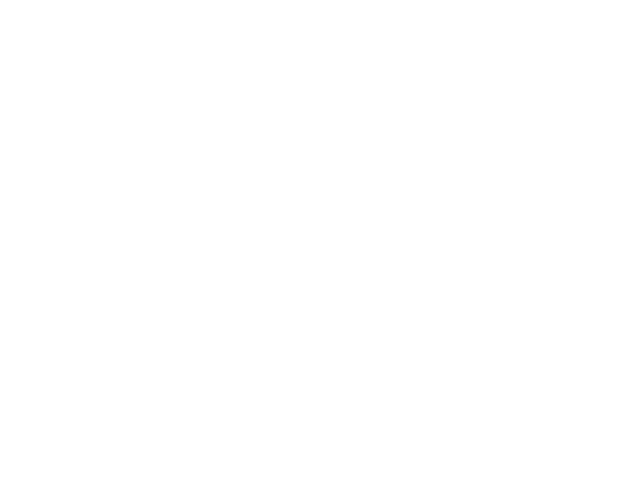

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


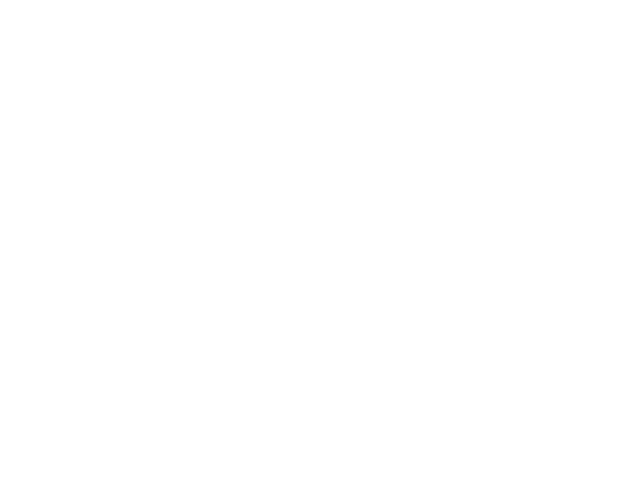

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


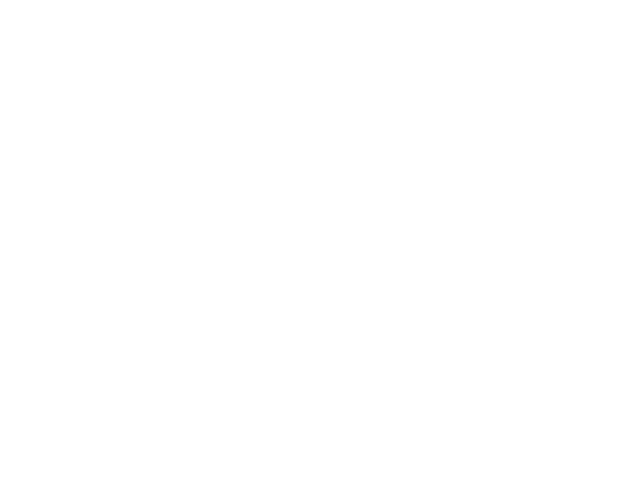

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


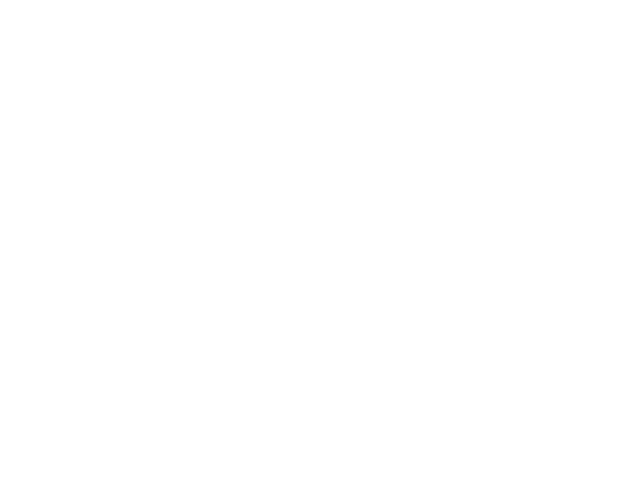

<IPython.core.display.Javascript object>


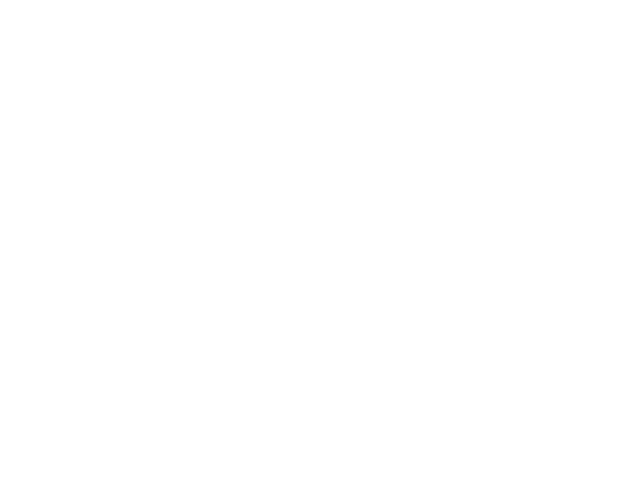

<IPython.core.display.Javascript object>


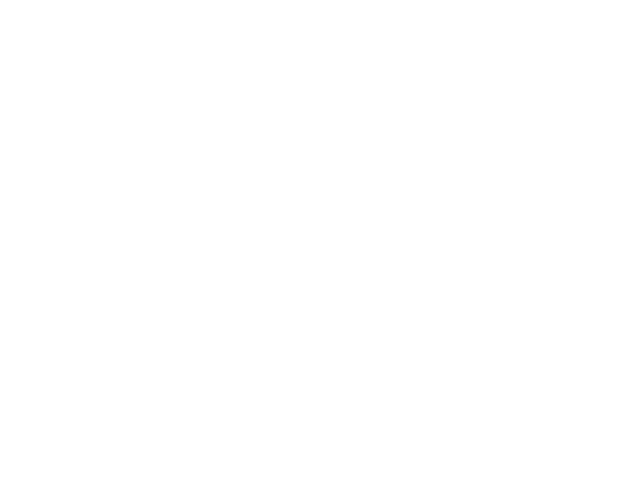

<IPython.core.display.Javascript object>


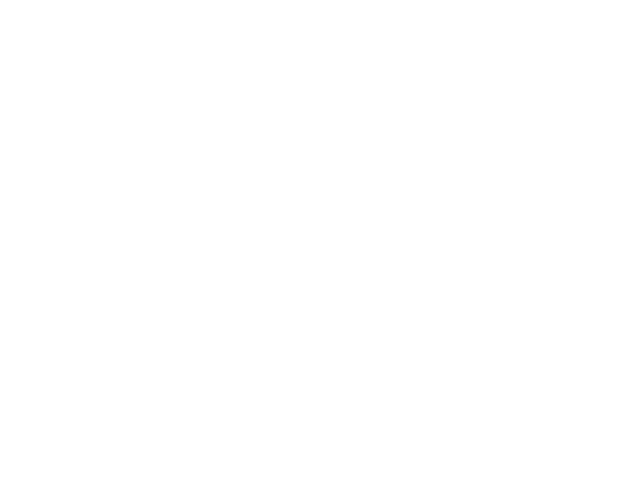

<IPython.core.display.Javascript object>


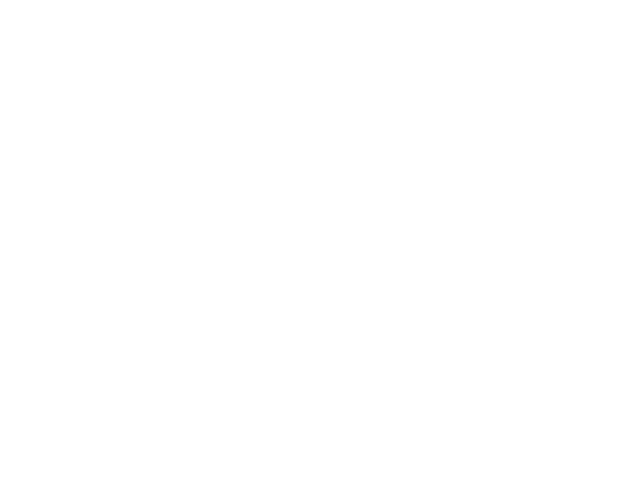

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


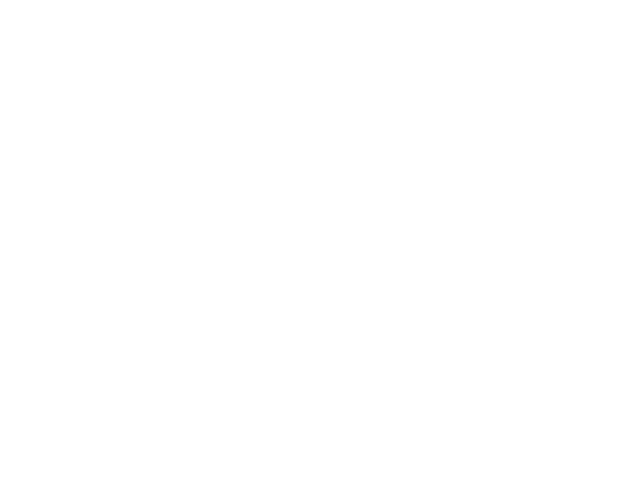

<IPython.core.display.Javascript object>


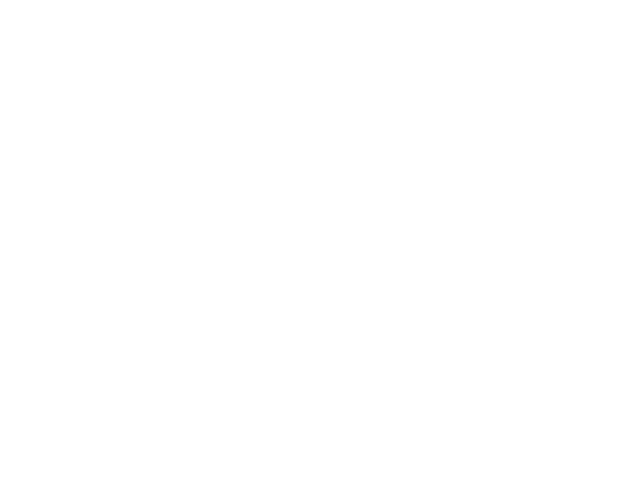

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


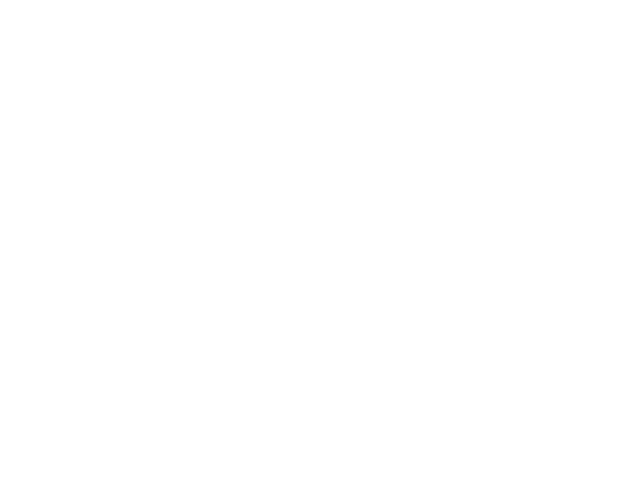

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


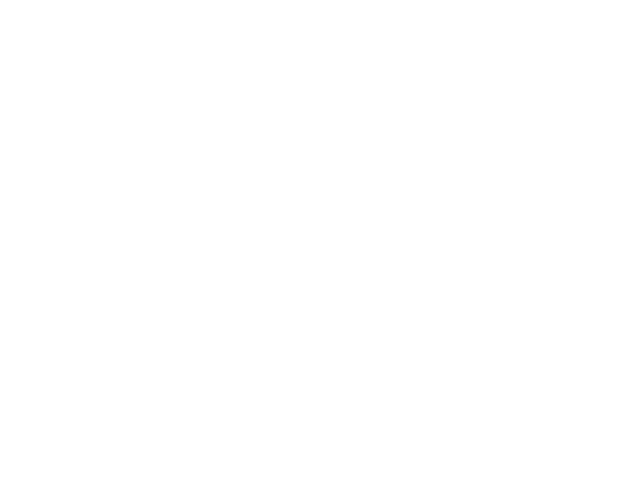

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


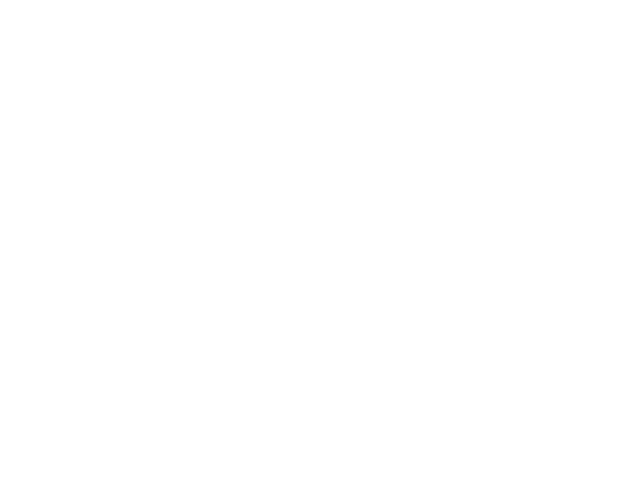

<IPython.core.display.Javascript object>


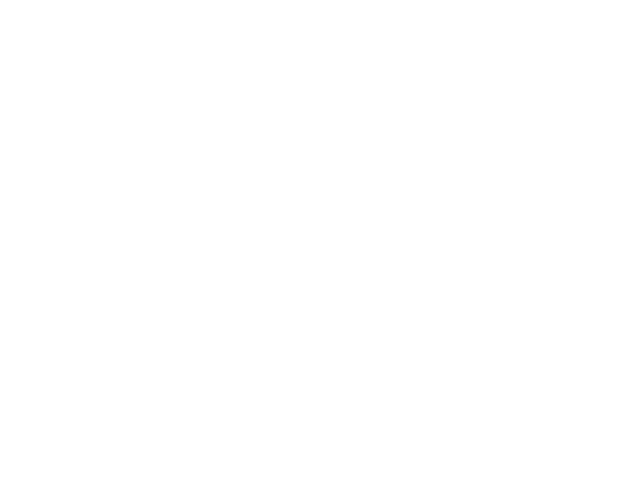

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


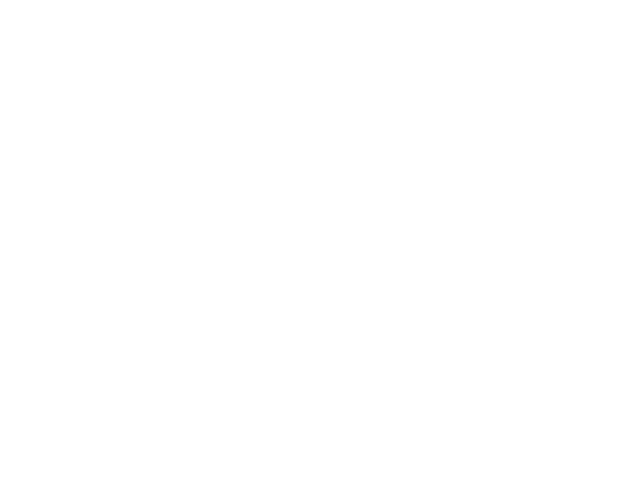

<IPython.core.display.Javascript object>


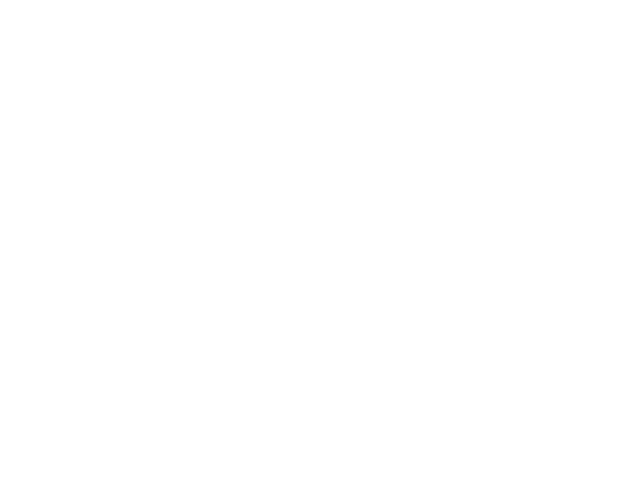

<IPython.core.display.Javascript object>


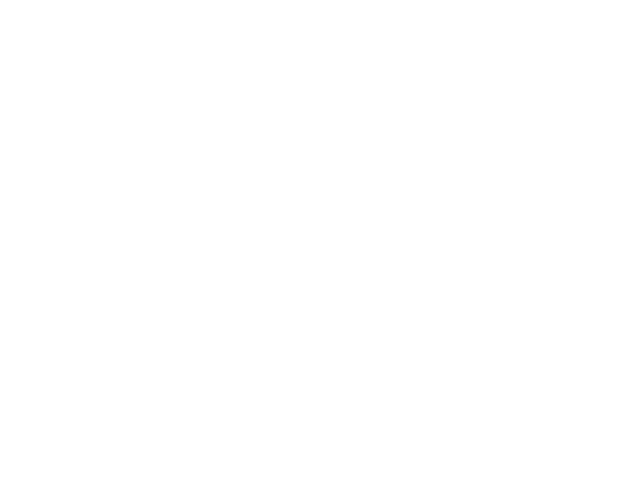

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


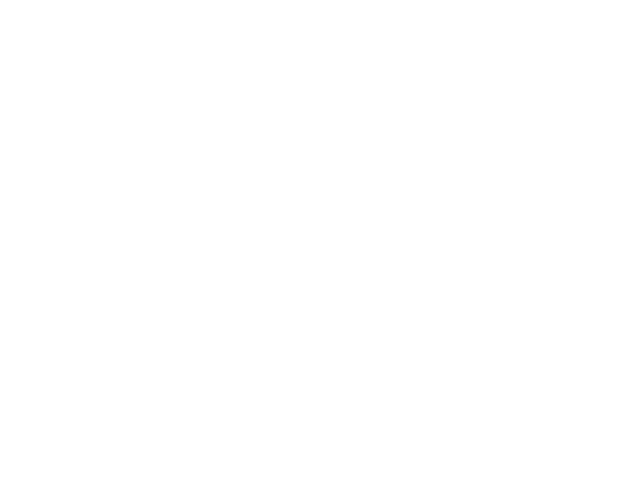

<IPython.core.display.Javascript object>


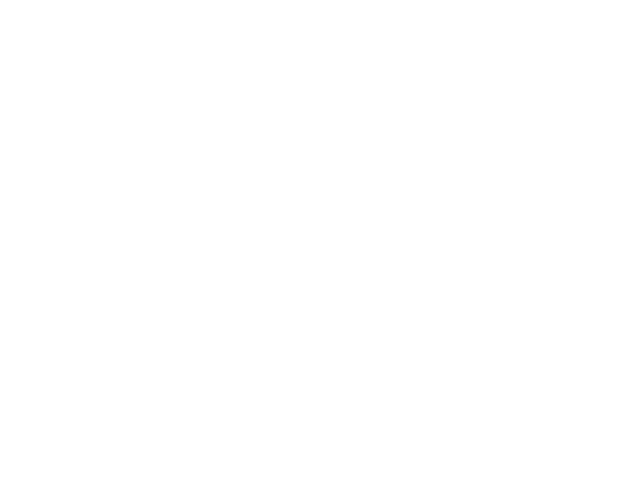

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


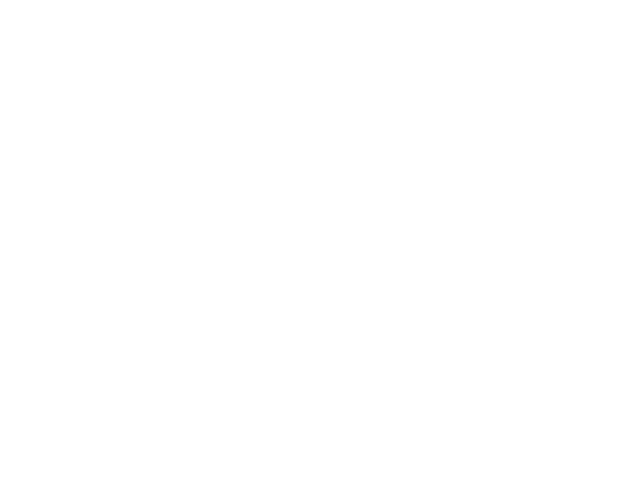

<IPython.core.display.Javascript object>


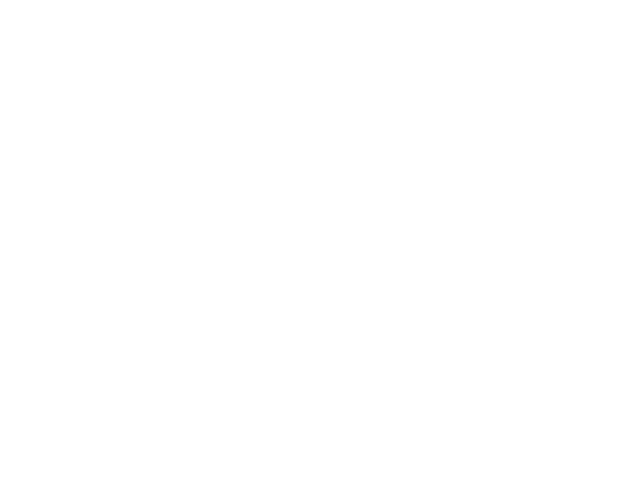

<IPython.core.display.Javascript object>


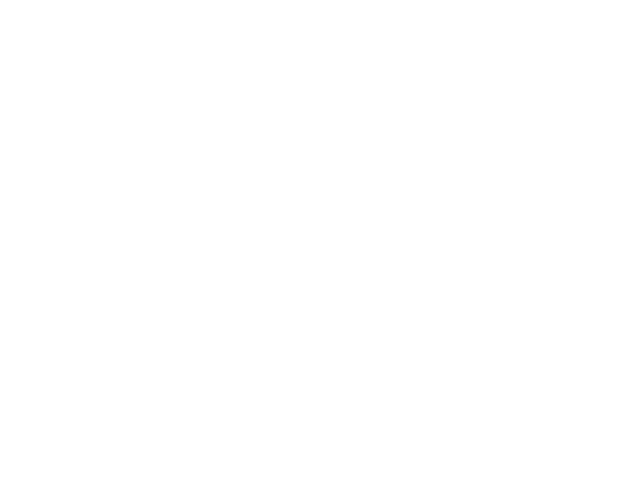

<IPython.core.display.Javascript object>


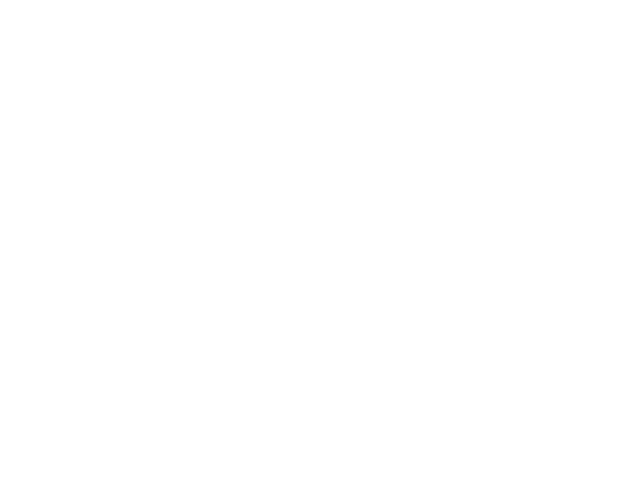

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


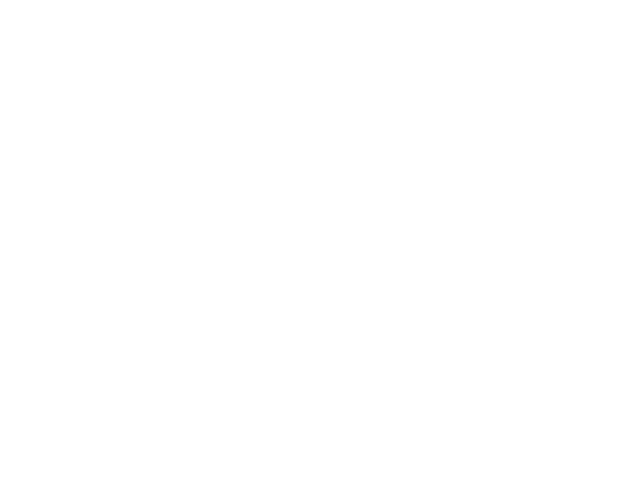

<IPython.core.display.Javascript object>


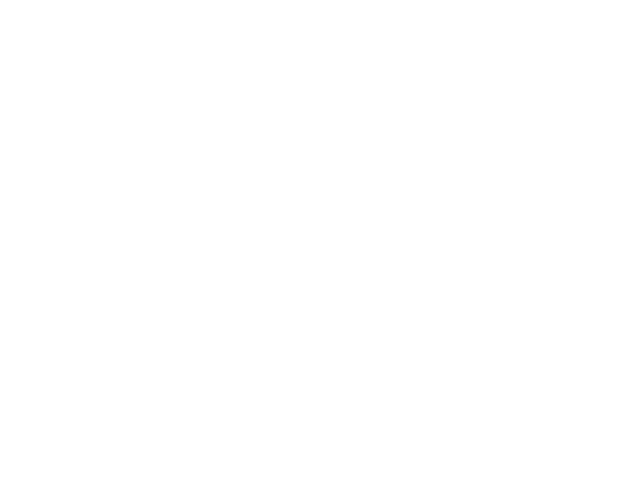

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


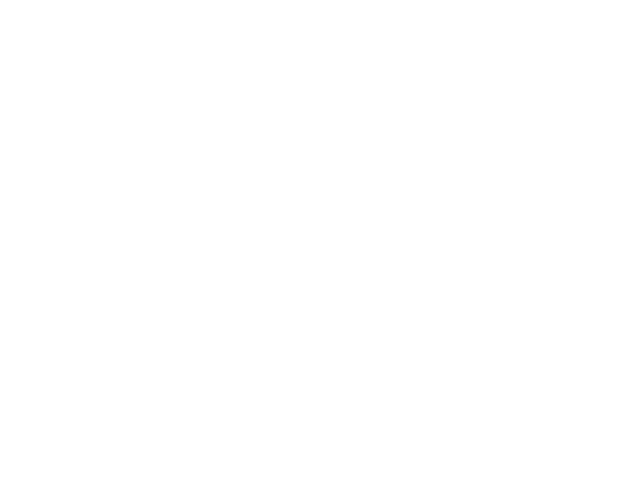

<IPython.core.display.Javascript object>


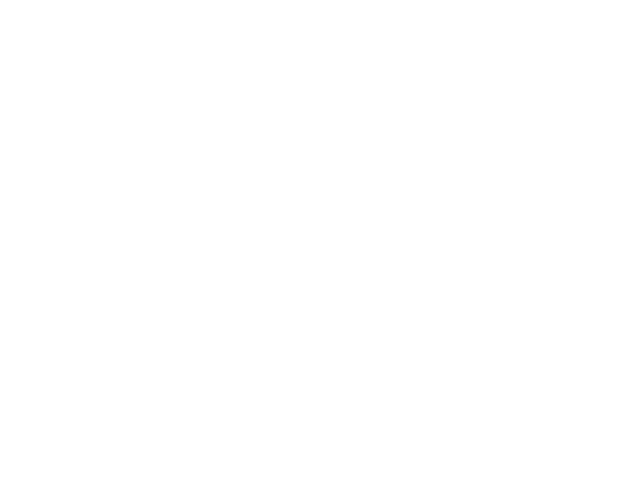

<IPython.core.display.Javascript object>


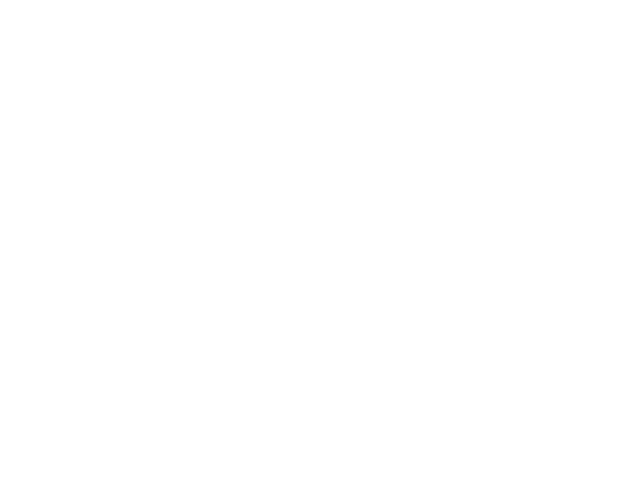

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


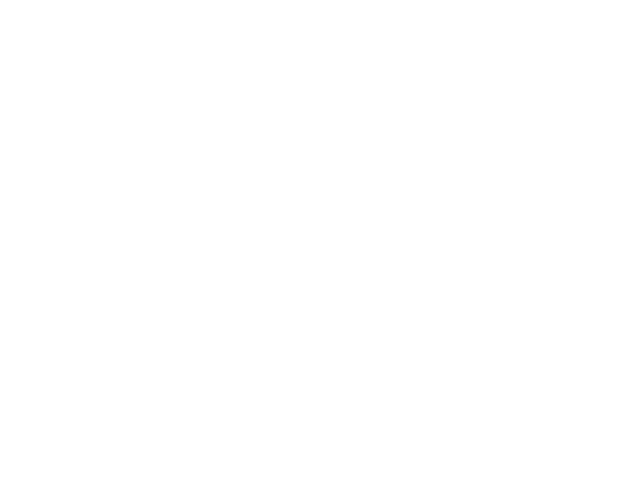

<IPython.core.display.Javascript object>


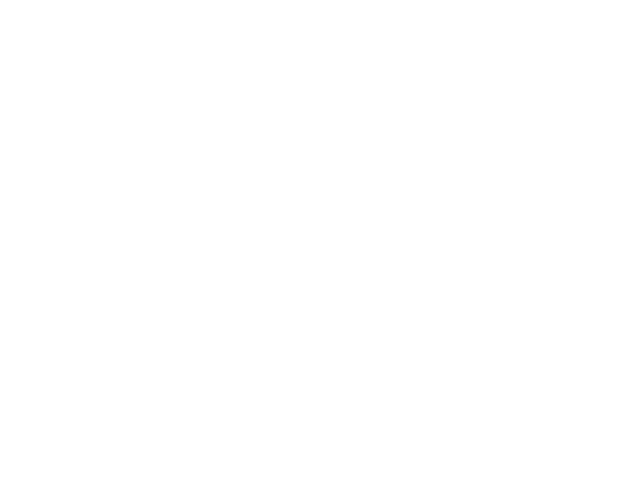

<IPython.core.display.Javascript object>


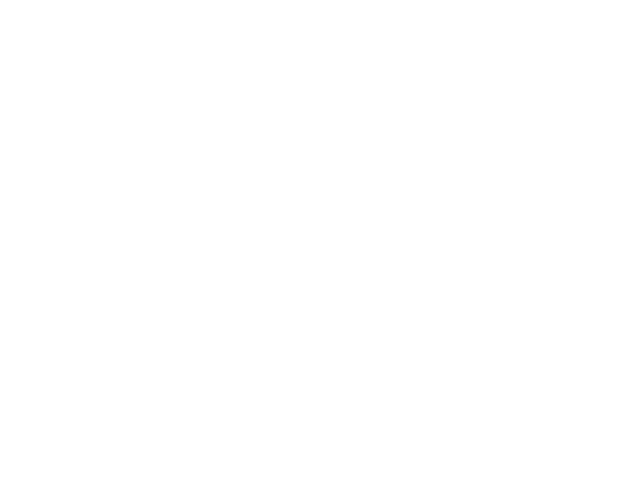

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


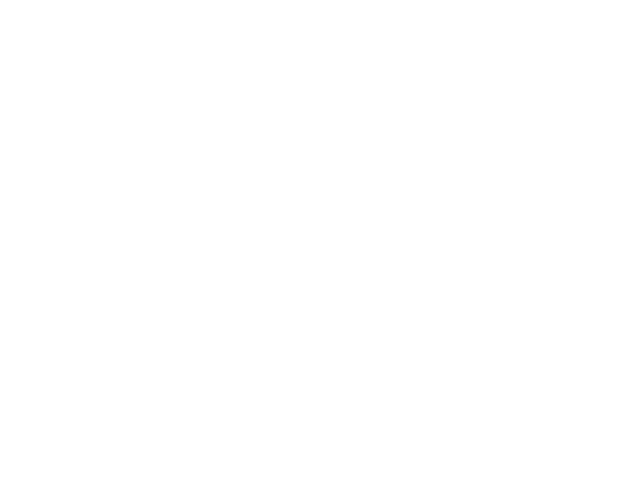

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


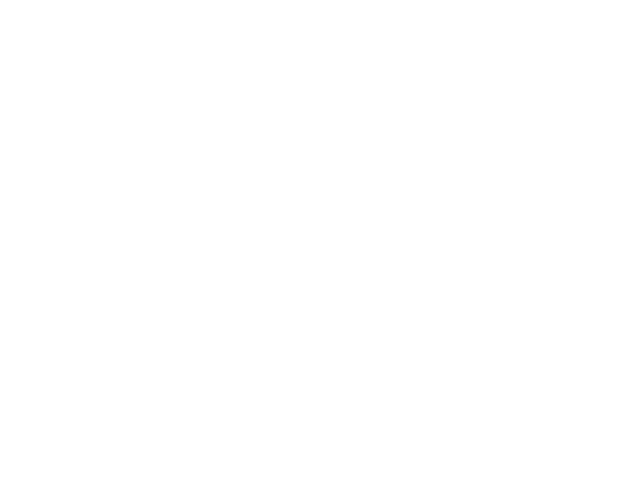

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


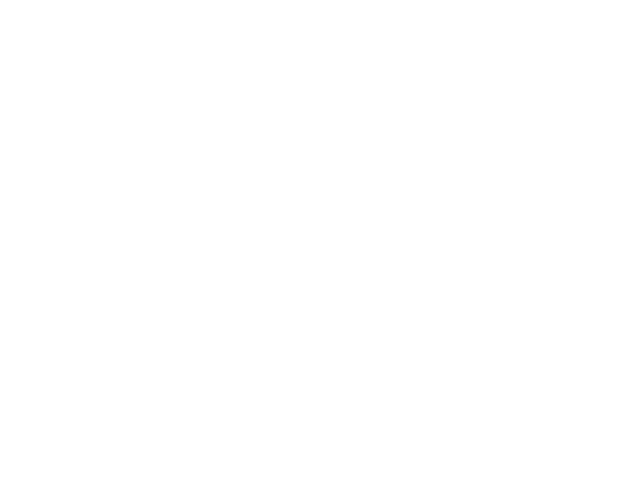

<IPython.core.display.Javascript object>


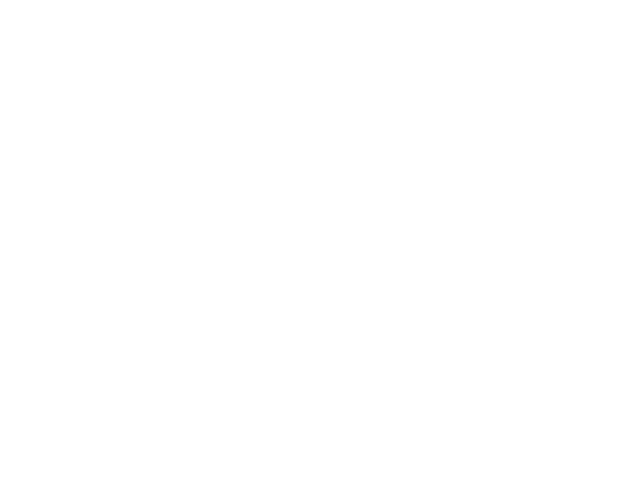

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


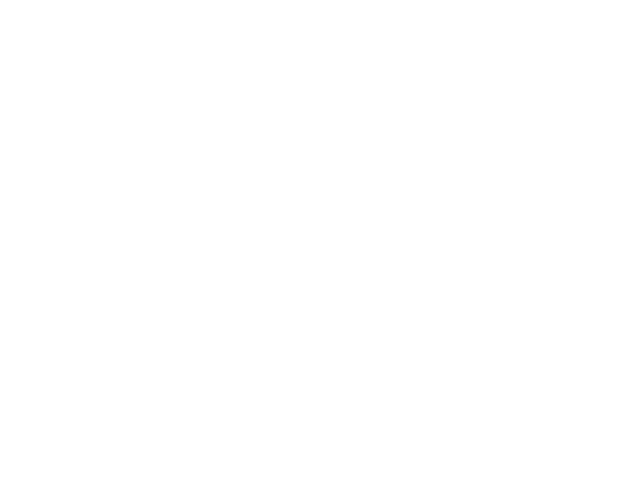

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


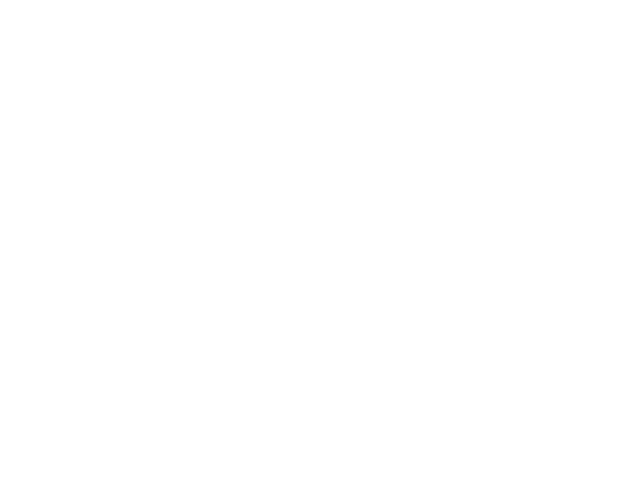

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


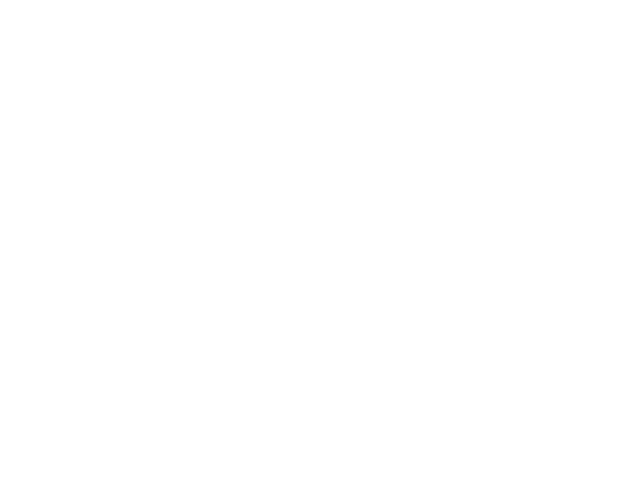

<IPython.core.display.Javascript object>


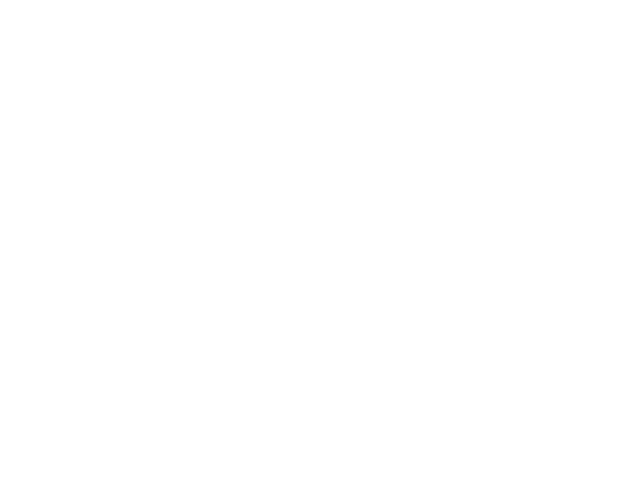

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


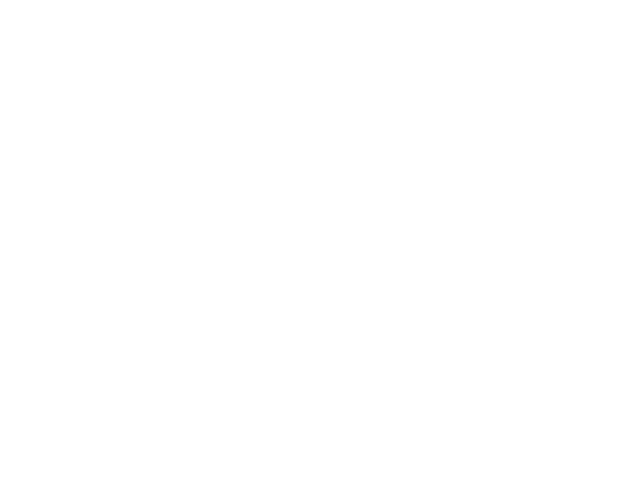

<IPython.core.display.Javascript object>


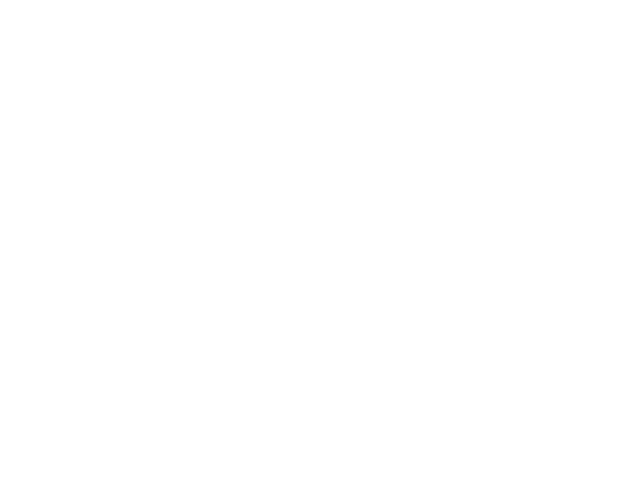

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


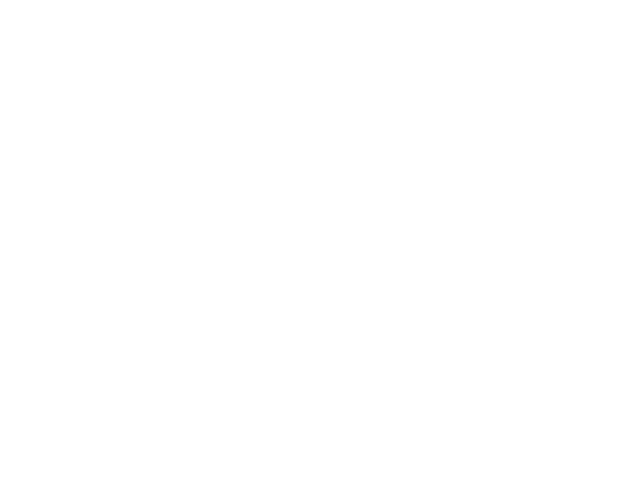

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


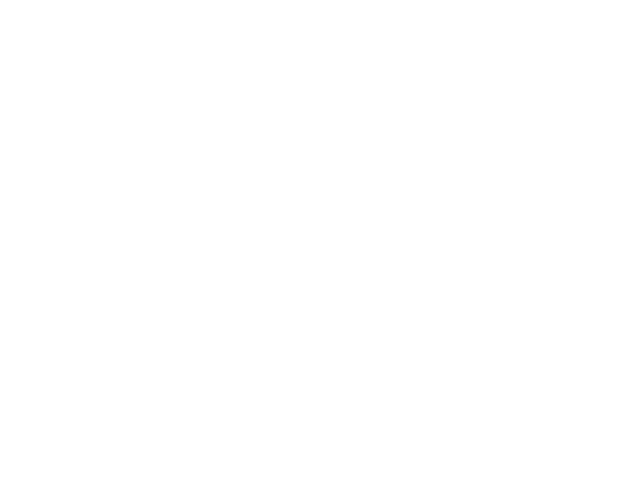

<IPython.core.display.Javascript object>


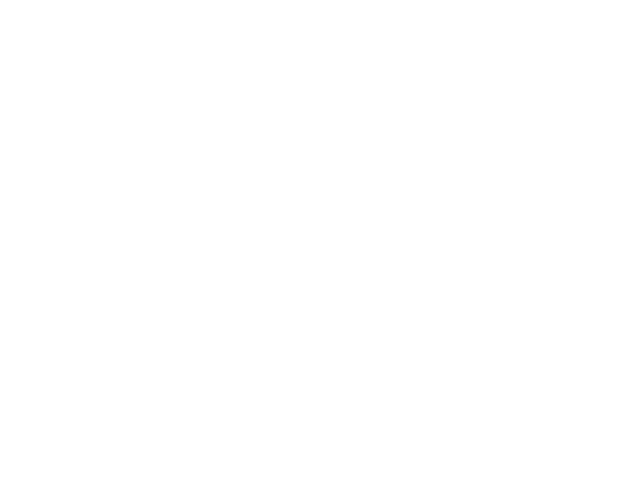

<IPython.core.display.Javascript object>


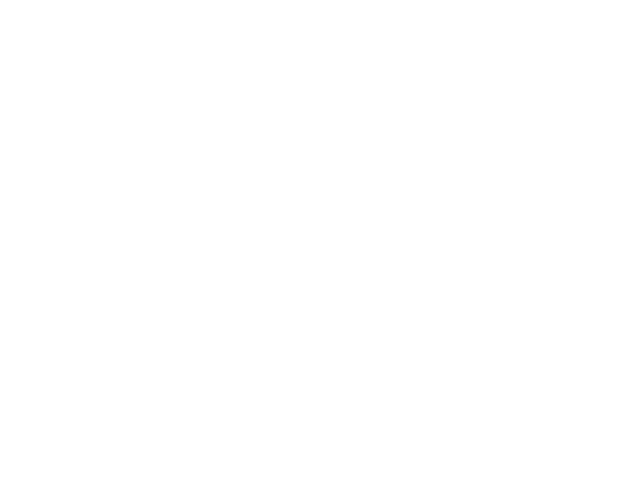

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


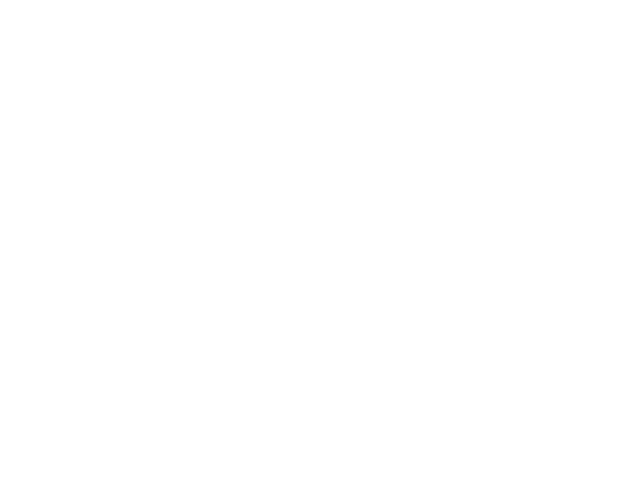

<IPython.core.display.Javascript object>


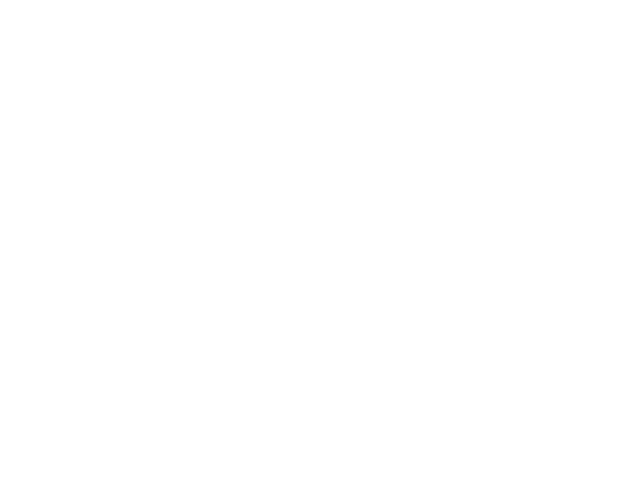

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


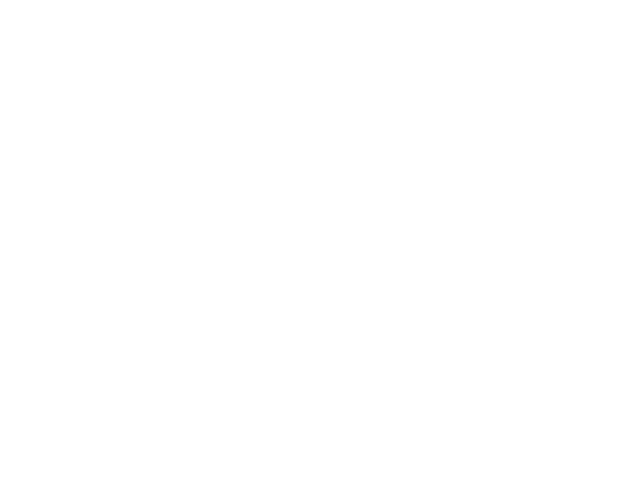

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


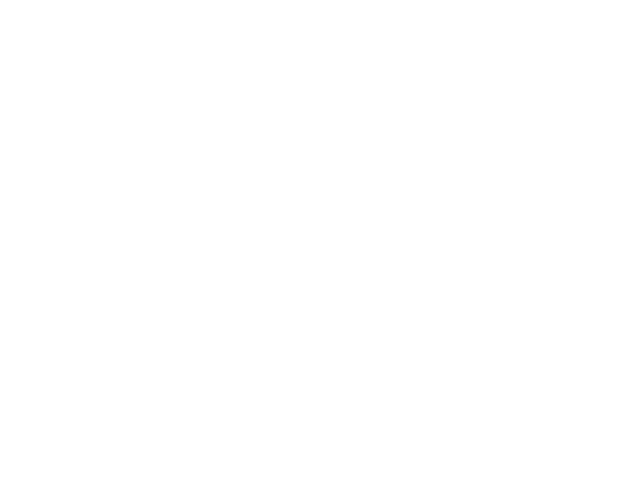

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


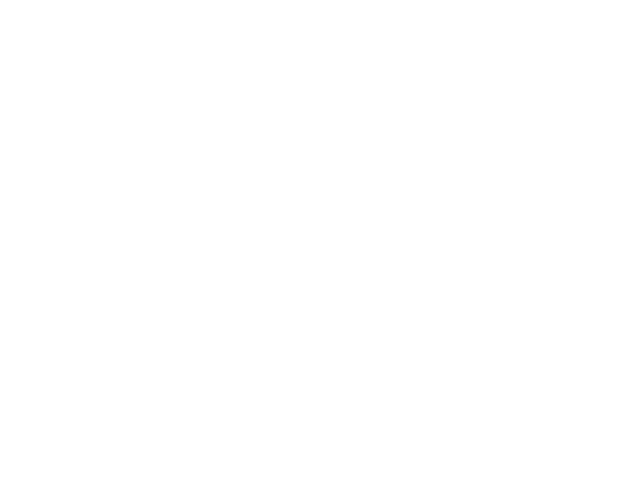

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


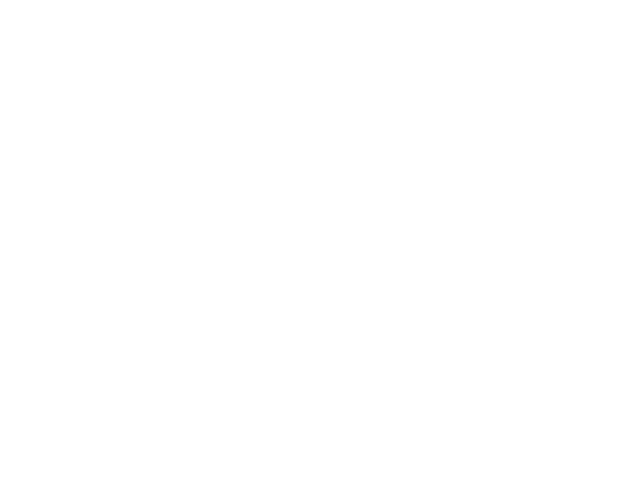

<IPython.core.display.Javascript object>


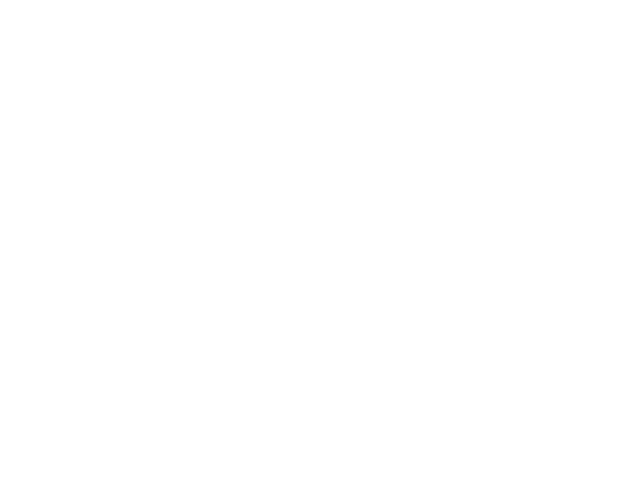

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


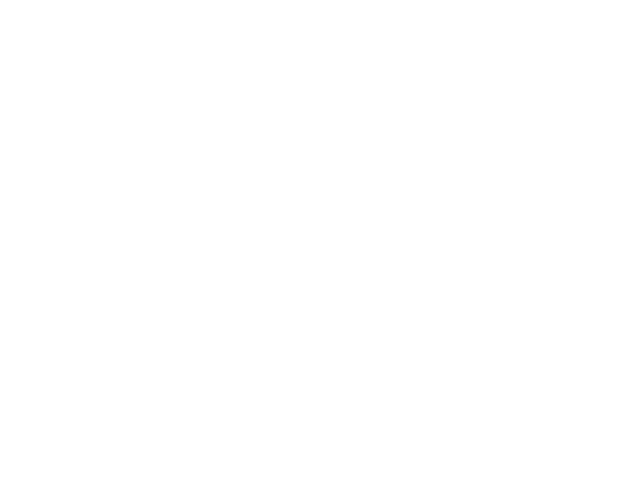

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


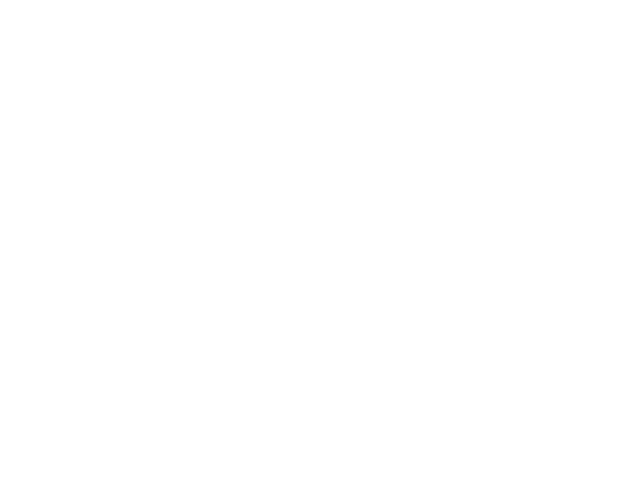

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


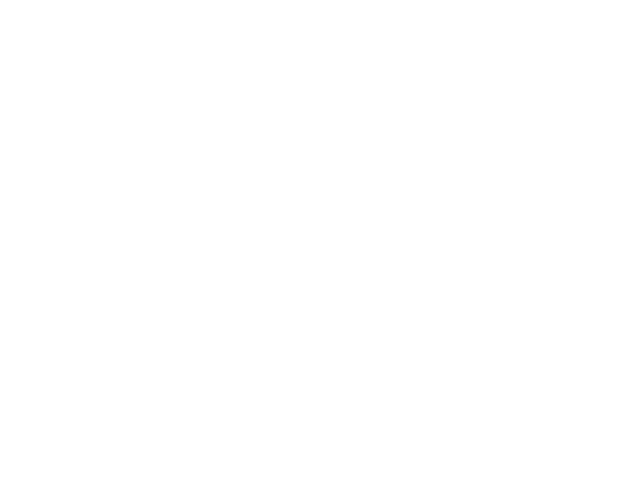

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


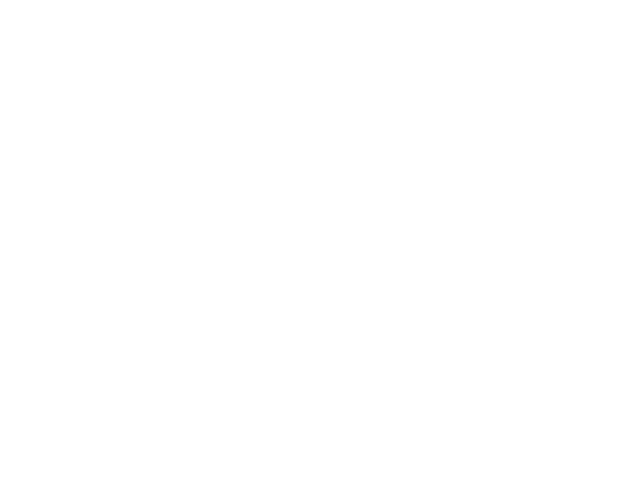

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


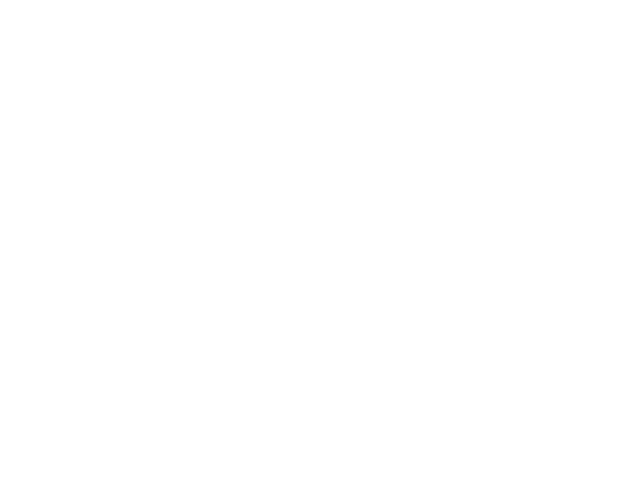

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


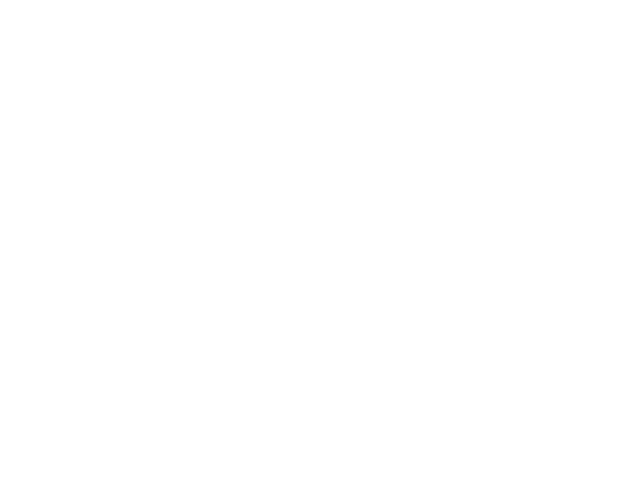

<IPython.core.display.Javascript object>


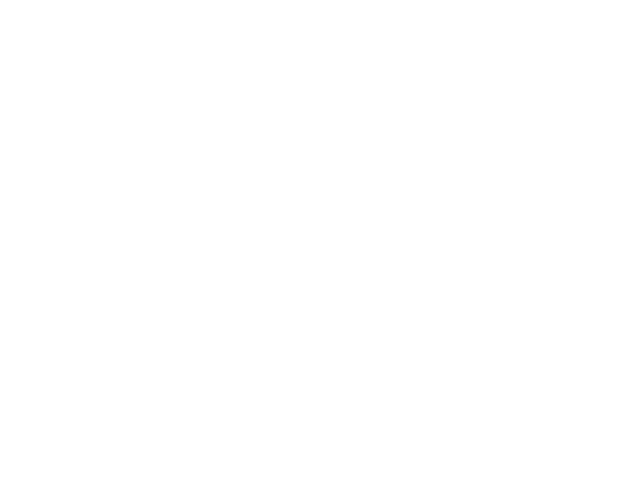

<IPython.core.display.Javascript object>


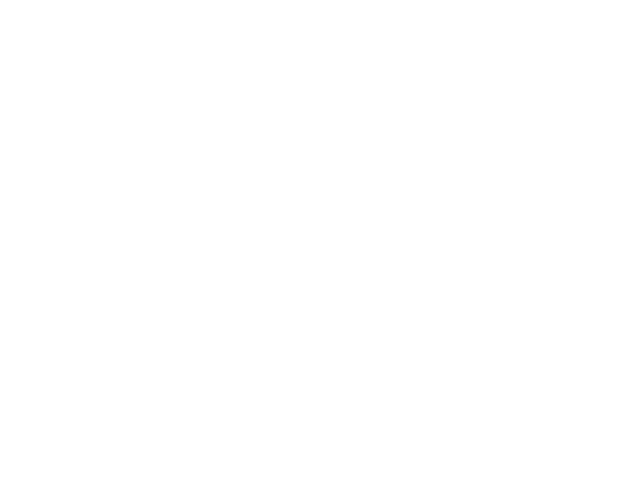

<IPython.core.display.Javascript object>


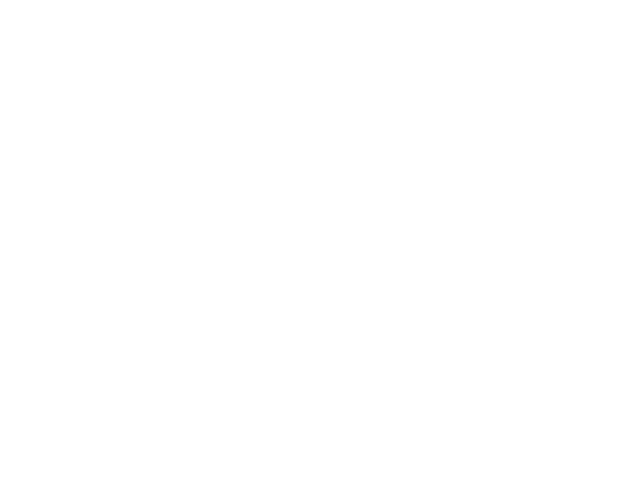

<IPython.core.display.Javascript object>


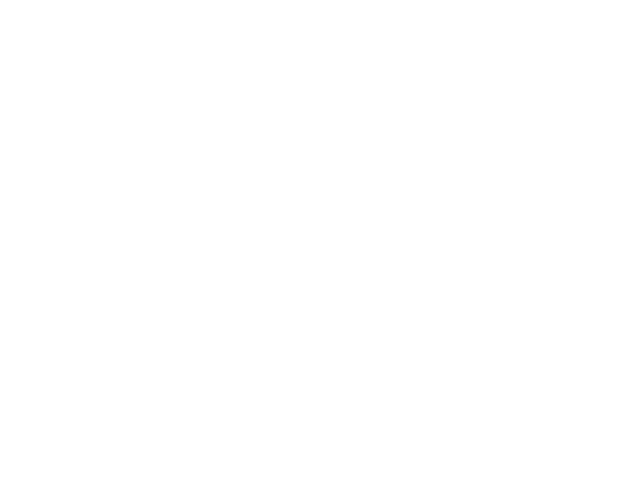

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


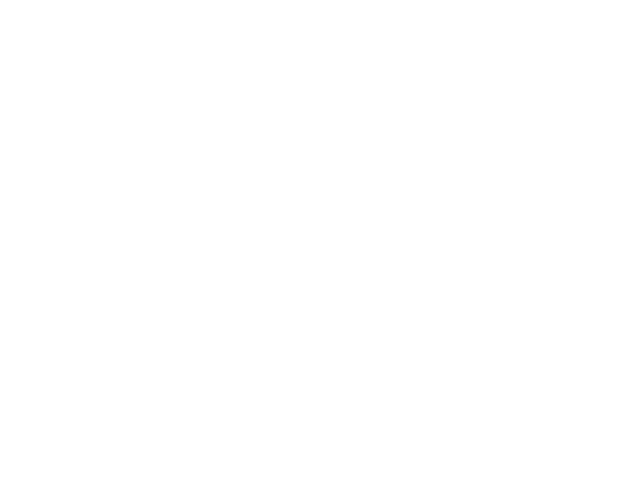

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


<IPython.core.display.Javascript object>


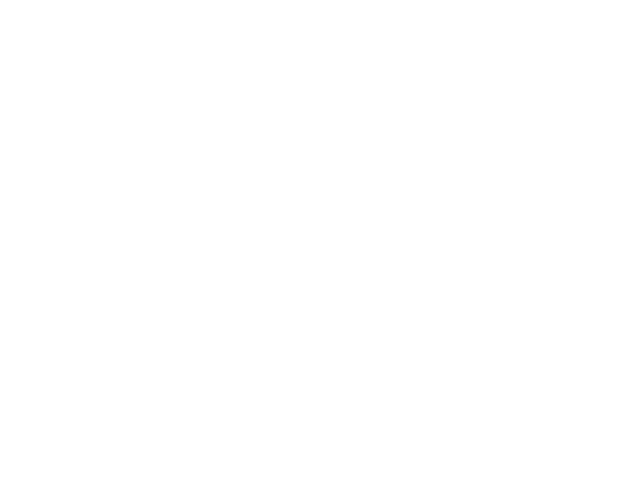

<IPython.core.display.Javascript object>


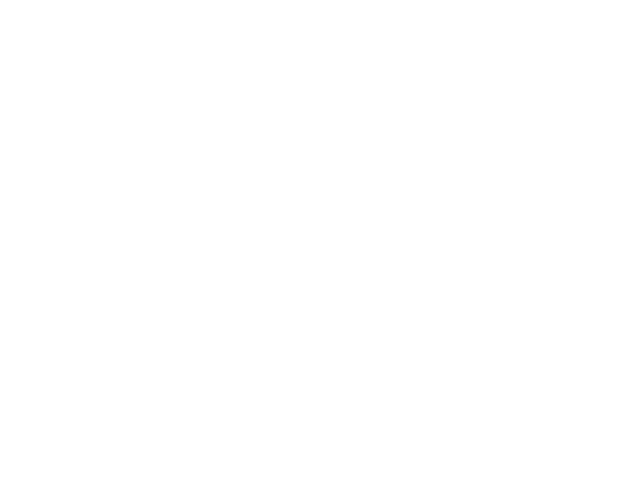

In [355]:
zps = np.zeros((84,100)) * np.nan
for j in range(84):
    j += 1
    cind =  ((data['campaign'].values == 16) & (data['Channel'].values == j) & (kbe < 100))

    locus = np.array([col1[good],col3[good]])
    obs = np.array([(gb - rb)[cind],(kb - rb)[cind], (kbe + rbe)[cind]])
    ind = np.where((obs[0,:] <= 1) & (obs[0,:] > 0.5))[0]
    obs = obs[:,ind]
    #print(obs.shape)
    K0 = 25
    k0 = [25,0,0,0]
    kbds = [(22,2),(-.5,.5),(-.5,.5),(-.5,.5)]
    if obs.shape[1] > 5:
        res = minimize(SLR_fit,K0,args=(obs,locus,False))
        K0 = res.x
        res = minimize(SLR_fit,K0,args=(obs,locus,True))
        if len(res.x) < 2:
            zps[j] = res.x
        else:
            zps[j] = res.x[0]
        #err[j] = res.hess_inv
        
        
        K = res.x
        if len(K) > 1:
            zp = K[0]
            A = K[1:]
        else:
            zp = K[0]
            A = np.zeros(3)

        plt.figure()
        #plt.plot(obs[0,:]+ A[0] - A[1], obs[1,:]+ zp + A[2] - A[1],'r.',alpha=0.5)
        plt.errorbar(obs[0,:]+ A[0] - A[1], obs[1,:]+ zp + A[2] - A[1],
                     yerr=obs[2,:],fmt='.',alpha=0.4,label = 'Observed')
        #plt.plot(obs[0,:], obs[1,:]+ 25.368,'g.',alpha=0.5)
        plt.ylabel('Kep - r')
        plt.xlabel('g - r')
        plt.title('channel = {}, zp = {}'.format(j,np.round(zp,3)))
        plt.xlim(-0.6, 1.5)
        plt.ylim(-1, 1)
        plt.plot(locus[0,:], locus[1,:],'o',label='Stellar locus')
        plt.legend(loc=3)
        plt.savefig('./figs/Fit_channel_' + str(j) + '.png')
        plt.close()


# brute force error

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [381]:
zps = np.zeros((85,100)) * np.nan
for j in range(85):
    cind =  ((data['campaign'].values == 16) & (data['Channel'].values == j) & (kbe < 100))

    locus = np.array([col1[good],col3[good]])
    obs = np.array([(gb - rb)[cind],(kb - rb)[cind], (kbe + rbe)[cind]])
    ind = np.where((obs[0,:] <= 1) & (obs[0,:] > 0.5))[0]
    obs = obs[:,ind]
    if obs.shape[1] > 20:
        for k in range(100):
            #print(obs.shape)
            K0 = 25
            k0 = [25,0,0,0]
            kbds = [(22,2),(-.5,.5),(-.5,.5),(-.5,.5)]
            removal = np.random.randint(0,obs.shape[1],size=15)
            sample = obs.copy()
            sample[:,removal] = np.nan
            res = minimize(SLR_fit,K0,args=(obs,locus,False))
            K0 = res.x
            res = minimize(SLR_fit,K0,args=(obs,locus,True))
            if len(res.x) < 2:
                zps[j,k] = res.x
            else:
                zps[j,k] = res.x[0]
    print(np.nanmedian(zps[j]))

nan
25.33335066714724
25.37299797666458
25.285835289160183
25.27245018216496
nan
nan
nan
nan
nan
nan
nan
nan
25.294659118563924
25.267436354427353
25.261742627249586
25.26231172498158
nan
nan
nan
nan
25.436112155920455
25.40093353567153
25.38685792043917
25.4053069387299
25.39407144186631
25.406368318731097
25.394509210848494
25.36439307149176
25.354038367048183
25.34088804663755
25.291671683911343
25.297609812900816
25.301860038170158
25.32244728844802
25.244501004009393
25.289321067422577
25.39010156408054
25.39650083809832
25.3827291253831
25.378600693715743
25.35254129161285
25.37876982529403
25.38926482807586
25.33962096940587
25.376289591304378
25.37430264144396
25.35614415884635
25.32671731706772
25.340499287758043
25.34769179538293
25.238058550077184
25.22131080792925
25.33277240320293
25.34528370191655
25.337985837688322
25.31150955526524
25.402125646869475
25.41344832375873
25.37997400142306
25.362446071750952
25.35778593442541
25.36649596836091
25.363751773235276
25.36919582

In [10]:
colours = {}
colours['obs g-r'] = np.array([(gb - rb)[cind], (gbe + rbe)[cind]])
colours['obs k-i'] = np.array([(kb - ib)[cind], (kbe + ibe)[cind]])
colours['obs k-r'] = np.array([(kb - rb)[cind], (kbe + rbe)[cind]])
colours['obs r-i'] = np.array([(rb - ib)[cind], (rbe + ibe)[cind]])
colours['obs g-k'] = np.array([(gb - kb)[cind], (gbe + kbe)[cind]])
colours['mod g-r'] = col1[good]
colours['mod r-i'] = col2[good]
colours['mod k-r'] = col3[good]
colours['mod k-i'] = col4[good]
colours['mod g-k'] = col5[good]

In [11]:
zp0 = 25
Ak0 = Ag0 = Ar0 = Ai0 = 0
k0 = [zp0,Ak0,Ag0,Ar0,Ai0]

In [9]:
def Dist_tensor(X,Y,Params,Colours,Second,Plot = False):
    keys = np.array(list(Colours.keys()))
    xind = 'mod ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'mod ' + Y == keys
    y = Colours[keys[yind][0]]
    
    x_interp = np.arange(np.nanmin(x),0.9,0.01)
    inter = interpolate.interp1d(x,y)
    l_interp = inter(x_interp)
    locus = np.array([x_interp,l_interp])
    # observed
    xind = 'obs ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'obs ' + Y == keys
    y = Colours[keys[yind][0]]
    #print(X,Y)
    c1,c2 = X.split('-')
    c3,c4 = Y.split('-')
    #print(c1,c2,c3,c4)
    
    # parameters
    ob_x = x.copy() 
    ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
    if c1 == 'k': ob_x += Params['kzp']
    if c2 == 'k': ob_x -= Params['kzp']

    ob_y = y.copy() 
    ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
    if c3 == 'k': ob_y[0,:] += Params['kzp']
    if c4 == 'k': ob_y[0,:] -= Params['kzp']
    
    ind = np.where((ob_x[0,:] <= 1) & (ob_x[0,:] >= 0.5))[0]
    ob_x = ob_x[:,ind]
    ob_y = ob_y[:,ind]
    if Plot:
        plt.figure()
        plt.title(X + ' ' + Y)
        plt.plot(ob_x[0,:],ob_y[0,:],'.')
        plt.plot(locus[0,:],locus[1,:])
    #print(ob_x.shape)
    dist_tensor = []
    for i in range(ob_y.shape[1]):
        dist = np.sqrt((ob_x[0,i] - locus[0,:])**2 + (ob_y[0,i] - locus[1,:])**2) 
        if Second:
            # Quality control
            #dist[dist > 6*(c[2,i])] = np.nan
            dist[dist > 1] = np.nan
        # add the normalised distance
        dist_tensor += [dist / ob_y[1,i]]
        if (c1 == 'k') | (c2 == 'k') | (c3 == 'k') | (c4 == 'k'):
            dist_tensor = dist_tensor * 2
    dist_tensor = np.array(dist_tensor)
    #print(dist_tensor.shape)
    if len(dist_tensor) > 20:
        residual = np.nansum(np.nanmin(abs(dist_tensor),axis=1))
    else:
        residual = 1000000
    #print(residual)
    return residual
    
def SLR_fit_multi(K,Colours,Compare,Second):
    
    params = {}
    params['kzp'] = K[0]
    params['Ak'] = K[1]
    params['Ag'] = K[2]
    params['Ar'] = K[3]
    params['Ai'] = K[4]
    res = 0
    for x,y in Compare:
        res += Dist_tensor(x,y,params,Colours,Second)
    return res
    

In [18]:
colours = {}
colours['obs g-r'] = np.array([(gb - rb), (gbe + rbe)])
colours['obs k-i'] = np.array([(kb - ib), (kbe + ibe)])
colours['obs k-r'] = np.array([(kb - rb), (kbe + rbe)])
colours['obs r-i'] = np.array([(rb - ib), (rbe + ibe)])
colours['obs g-k'] = np.array([(gb - kb), (gbe + kbe)])
colours['mod g-r'] = col1[good]
colours['mod r-i'] = col2[good]
colours['mod k-r'] = col3[good]
colours['mod k-i'] = col4[good]
colours['mod g-k'] = col5[good]

compare = np.array([['g-r','k-r'],['g-r','k-i'],['g-r','r-i'],['r-i','g-k']])

In [17]:
colours = {}
colours['obs g-r'] = np.array([(gb - rb)[cind], (gbe + rbe)[cind]])
colours['obs k-i'] = np.array([(kb - ib)[cind], (kbe + ibe)[cind]])
colours['obs k-r'] = np.array([(kb - rb)[cind], (kbe + rbe)[cind]])
colours['obs r-i'] = np.array([(rb - ib)[cind], (rbe + ibe)[cind]])
colours['obs g-k'] = np.array([(gb - kb)[cind], (gbe + kbe)[cind]])
colours['mod g-r'] = col1[good]
colours['mod r-i'] = col2[good]
colours['mod k-r'] = col3[good]
colours['mod k-i'] = col4[good]
colours['mod g-k'] = col5[good]

compare = np.array([['g-r','k-r'],['g-r','k-i'],['g-r','r-i'],['r-i','g-k']])

In [92]:
colours['obs k-r'][1,:]

array([6.99199851e+00, 2.99765477e-02, 3.53040575e-03, 1.90712192e+01,
       4.54118571e-01, 3.65685297e-02, 8.69272019e-03, 7.34629363e-03,
       2.49231859e+01, 8.94683360e-02, 8.09908823e-03, 1.29984965e-02,
       1.11753047e-02, 6.96516611e-03, 1.05651253e-02, 9.16609815e-03,
       7.83407833e-03, 3.27346232e-02, 2.08917394e-02, 9.36130946e-03,
       1.79976297e-02, 7.84954544e-03, 1.77595652e-02, 1.89352109e+01,
       7.04751754e-03, 6.66234127e-03, 5.21927173e-03, 5.21477628e-01,
       4.47978878e-03, 2.69453446e-02, 4.34845842e-02, 5.27652016e-03,
       3.40378925e-03, 6.84506749e-03, 1.85533251e-02, 3.82677107e-03,
       4.16005068e-03, 9.93465731e-03, 9.14716460e-02, 8.72445841e-03,
       6.92174967e-03, 6.38140382e-03, 3.17728824e-02, 1.57290411e-02,
       2.87618879e-02, 9.80937836e-03, 9.16390121e-03, 4.49532223e-02,
       1.10362491e-02, 7.67541505e-03, 4.68300199e-03, 5.79079633e-03,
       1.34445042e-01, 2.15962845e-01, 5.75593347e-01, 4.04478302e-03,
      

In [15]:
SLR_fit_multi(k0,colours,compare,False)

699.8293731952535

In [14]:
zp0 = 25
Ak0 = Ag0 = Ar0 = Ai0 = 0
k0 = np.array([zp0,Ak0,Ag0,Ar0,Ai0])
bds = [(20,27),(-2,2),(-2,2),(-2,2),(-2,2)]

In [21]:
res = minimize(SLR_fit_multi,k0,args=(colours,compare,False),bounds=bds)

In [22]:
res.x

array([ 2.52978582e+01,  0.00000000e+00, -7.06575122e-02, -6.56640802e-02,
       -2.28286687e-02])

In [24]:
k0 = res.x
res = minimize(SLR_fit_multi,k0,args=(colours,compare,False),bounds=bds)

<IPython.core.display.Javascript object>


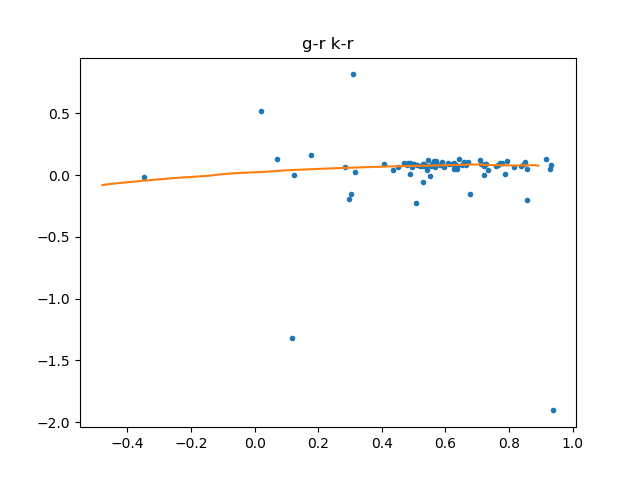

<IPython.core.display.Javascript object>


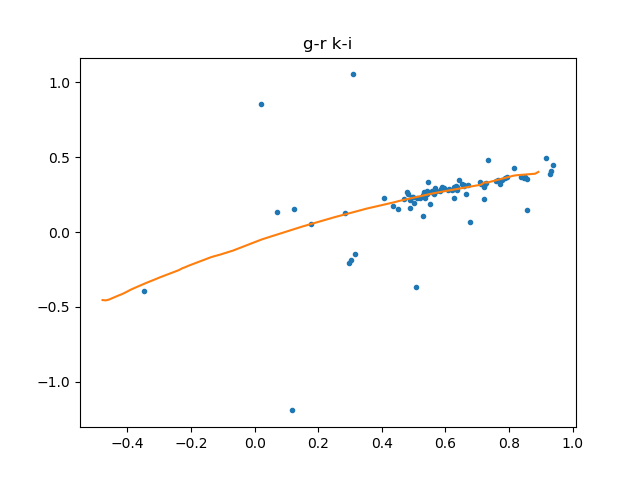

<IPython.core.display.Javascript object>


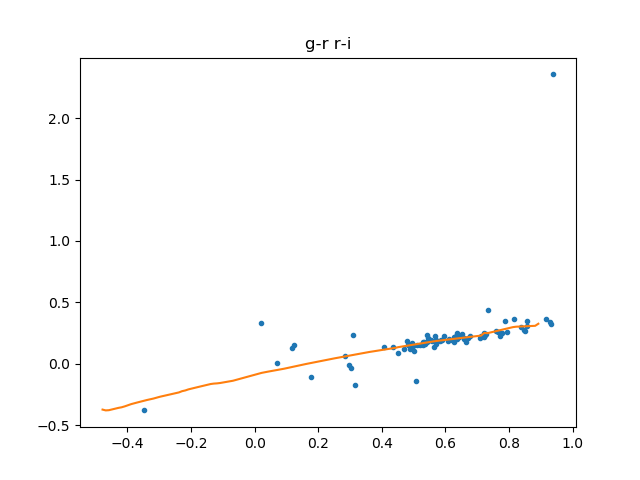

<IPython.core.display.Javascript object>


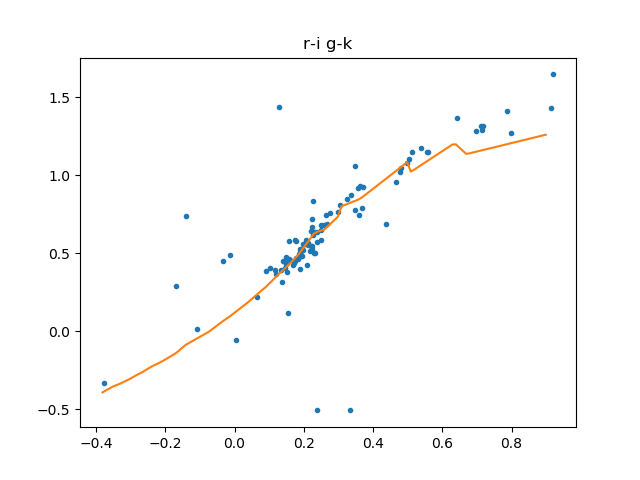

In [25]:
K = res.x
params = {}
params['kzp'] = K[0]
params['Ak'] = K[1]
params['Ag'] = K[2]
params['Ar'] = K[3]
params['Ai'] = K[4]

for x,y in compare:
    Dist_tensor(x,y,params,colours,False,Plot= True)

In [38]:
len(compare)

4

In [15]:
def Plotter(K,Colours,Compare,Channel):
    Params = {}
    Params['kzp'] = K[0]
    Params['Ak'] = K[1]
    Params['Ag'] = K[2]
    Params['Ar'] = K[3]
    Params['Ai'] = K[4]
    plt.figure(figsize=(10,6))
    plt.suptitle('Channel ' + str(Channel) + ', Zp = ' + str(np.round(K[0],2)))
    for i in range(len(Compare)):
        X,Y = Compare[i]
        keys = np.array(list(Colours.keys()))
        xind = 'mod ' + X == keys
        x = Colours[keys[xind][0]]
        yind = 'mod ' + Y == keys
        y = Colours[keys[yind][0]]

        x_interp = np.arange(np.nanmin(x),0.9,0.01)
        inter = interpolate.interp1d(x,y)
        l_interp = inter(x_interp)
        locus = np.array([x_interp,l_interp])
        # observed
        xind = 'obs ' + X == keys
        x = Colours[keys[xind][0]]
        yind = 'obs ' + Y == keys
        y = Colours[keys[yind][0]]
        #print(X,Y)
        c1,c2 = X.split('-')
        c3,c4 = Y.split('-')
        #print(c1,c2,c3,c4)

        # parameters
        ob_x = x.copy() 
        ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
        if c1 == 'k': ob_x += Params['kzp']
        if c2 == 'k': ob_x -= Params['kzp']

        ob_y = y.copy() 
        ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
        if c3 == 'k': ob_y[0,:] += Params['kzp']
        if c4 == 'k': ob_y[0,:] -= Params['kzp']

        ind = np.where((ob_x[0,:] <= 1) & (ob_x[0,:] > -0.5) & ((ob_y[1,:] < 5)))[0]
        ob_x = ob_x[:,ind]
        ob_y = ob_y[:,ind]
        
        plt.subplot(2,2,i+1)
        plt.xlabel(X)
        plt.ylabel(Y)
        plt.errorbar(ob_x[0,:],ob_y[0,:],ob_y[1,:],fmt='.',alpha=0.4)
        plt.plot(locus[0,:],locus[1,:])
        plt.xlim(-0.5, 1)
        plt.ylim(-.5, 1)
    plt.subplots_adjust(wspace=.2,hspace=.2)
    plt.savefig('./figs/Fit_channel_' + str(j) + '.png')
    plt.close()

In [ ]:
compare = np.array([['g-r','k-r'],['g-r','k-i'],['g-r','r-i'],['r-i','g-k']])
zps = np.zeros((84,100)) * np.nan
for j in range(84):
    j += 1
    cind =  ((data['campaign'].values == 16) & (data['Channel'].values == j) & (kbe < 100))

    colours = {}
    colours['obs g-r'] = np.array([(gb - rb)[cind], (gbe + rbe)[cind]])
    colours['obs k-i'] = np.array([(kb - ib)[cind], (kbe + ibe)[cind]])
    colours['obs k-r'] = np.array([(kb - rb)[cind], (kbe + rbe)[cind]])
    colours['obs r-i'] = np.array([(rb - ib)[cind], (rbe + ibe)[cind]])
    colours['obs g-k'] = np.array([(gb - kb)[cind], (gbe + kbe)[cind]])
    colours['mod g-r'] = col1[good]
    colours['mod r-i'] = col2[good]
    colours['mod k-r'] = col3[good]
    colours['mod k-i'] = col4[good]
    colours['mod g-k'] = col5[good]
    #print(obs.shape)
    zp0 = 25.4
    Ak0 = Ag0 = Ar0 = Ai0 = 0
    k0 = np.array([zp0,Ak0,Ag0,Ar0,Ai0])
    bds = [(22,27),(-2,2),(-2,2),(-2,2),(-2,2)]
    res = minimize(SLR_fit_multi,k0,args=(colours,compare,False),bounds=bds)
    K0 = res.x
    #res = minimize(SLR_fit_multi,k0,args=(colours,compare,True),bounds=bds)
    if len(res.x) < 2:
        zps[j] = res.x
    else:
        zps[j-1] = res.x[0]
        print(res.x[0])

    Plotter(res.x,colours,compare,j)


<IPython.core.display.Javascript object>


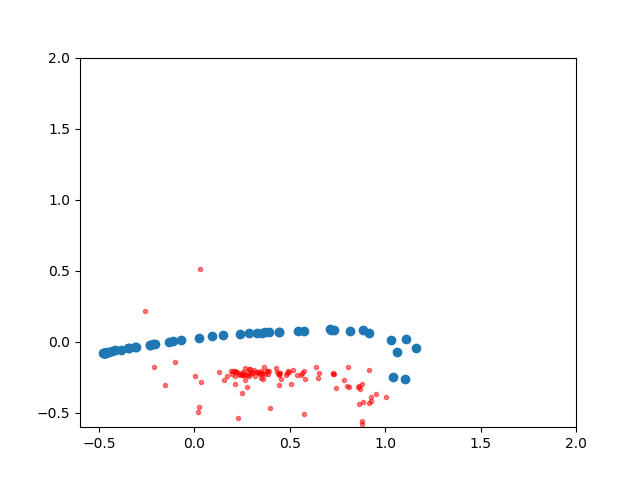

In [556]:
K = res.x
if len(K) > 1:
    zp = K[0]
    A = K[1:]
else:
    zp = K[0]
    A = np.zeros(3)

plt.figure()
plt.plot(colours['obs g-r'] + A[2] - A[3], colours['obs k-r']+ zp + A[0] - A[3],'r.',alpha=0.5)
#plt.plot(obs[0,:], obs[1,:]+ 25.368,'g.',alpha=0.5)
plt.xlim(-0.6, 2)
plt.ylim(-0.6, 2)
plt.plot(colours['mod g-r'], colours['mod k-r'],'o')


In [434]:
plt.

In [435]:
if a == 3 : print('eh')

eh


In [417]:
np.where('g-r' in key)

(array([], dtype=int64),)

<IPython.core.display.Javascript object>


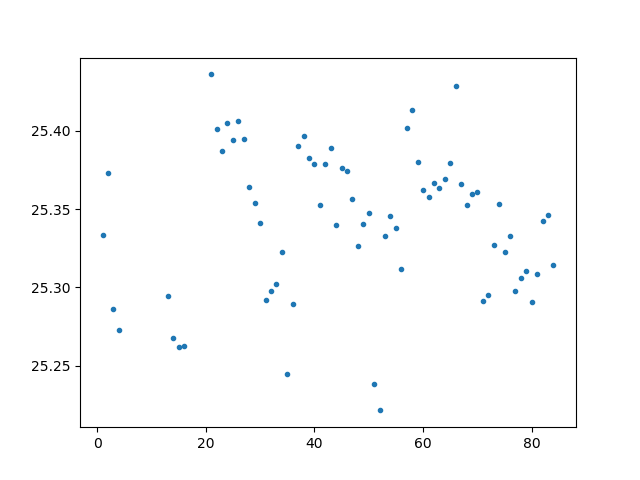

<ErrorbarContainer object of 3 artists>

In [387]:
plt.figure()
plt.errorbar(np.arange(0,85),np.nanmedian(zps,axis=1),yerr=np.nanstd(zps,axis=1),fmt='.')

<IPython.core.display.Javascript object>


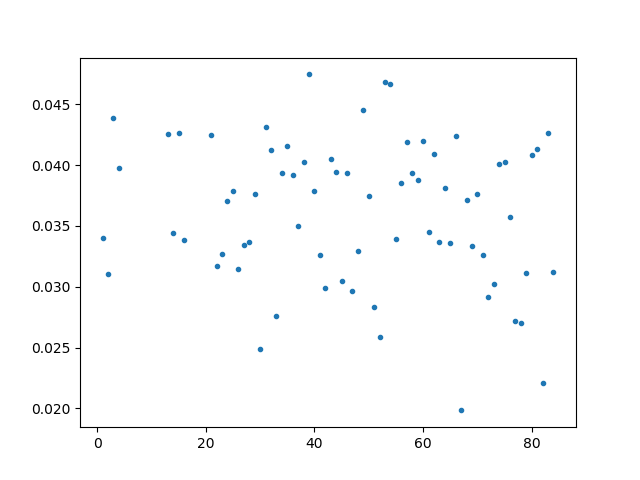

In [360]:
diff = zpr-zpi
plt.figure()
plt.plot(diff,'.')
plt.ylabel('')
#plt.errorbar(np.arange(0,84),zps,yerr=err,fmt='.')

In [307]:
z = zps[np.isfinite(zps)]

<IPython.core.display.Javascript object>


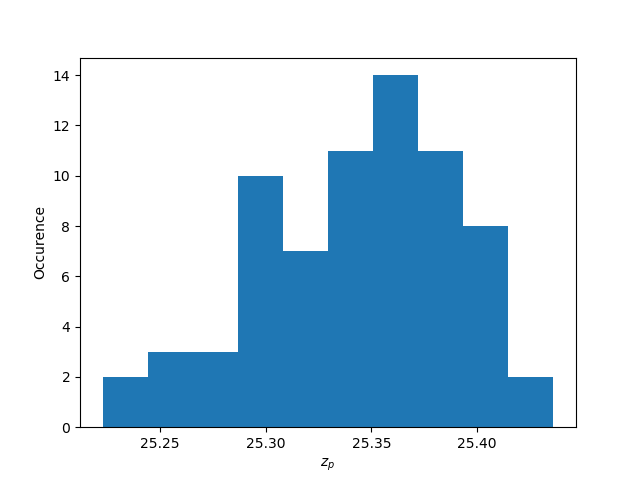

In [349]:
plt.figure()
plt.hist(z)
plt.ylabel('Occurence')
plt.xlabel('$z_p$')
plt.savefig('c16_zp.png')

In [ ]:
def Get_kep_zp(Target_list,Model_sed):
    
    
    color1 = 'ps1g_ps1r'
    color2 = 'ps1r_ps1i'
    col1 = []
    col2 = []
    col3 = []
    # construct color-color vectors
    for modelname in model_sed:
        model= model_sed[modelname]
        model = S.ArraySpectrum(model.wave, model.flux, name=modelname)
        c1, c2 = color1.split('_')
        pb1, zp1 = pbs[c1]
        pb2, zp2 = pbs[c2]
        c3, c4 = color2.split('_')
        c5 = 'Kep'
        pb3, zp3 = pbs[c3]
        pb4, zp4 = pbs[c4]
        pb5, zp5 = pbs[c5]
        thiscol1 = source_synphot.passband.syncolor(model, pb1, pb2, zp1, zp2)
        thiscol2 = source_synphot.passband.syncolor(model, pb3, pb4, zp3, zp4)
        thiscol3 = source_synphot.passband.syncolor(model, pb5, pb4, zp5, zp4)
        col1.append(thiscol1)
        col2.append(thiscol2)
        col3.append(thiscol3)
    col1 = np.array(col1)
    col2 = np.array(col2)
    col3 = np.array(col3)
    # select only useful objects
    good = ~np.isnan(col1)* ~np.isnan(col2)* ~np.isnan(col3)
    good = np.array(good)
    
    data = pd.read_csv(Target_list)
    data = data.iloc[(data['ps_score'].values > 0.9) & (data['PDC'].values > 0)]
    cind =  ((data['campaign'].values == 16) & (data['Channel'].values == 70))
    gb = data['gMeanPSFMag'].values
    rb = data['rMeanPSFMag'].values
    ib = data['iMeanPSFMag'].values
    kb = -2.5*np.log10(data['PDC'].values)